In [1]:
import sys
import numpy as np
import pandas as pd

from Dissects.io import (load_NDskl, 
                         load_image,
                         load_skeleton,
                         save_skeleton,
                         save_fits
                        )
from Dissects.image import z_project
from Dissects.geometry import Skeleton
from Dissects.segmentation.seg_2D import (segmentation, 
                                          junction_around_cell)
from Dissects.analysis.analysis import (general_analysis,
                              cellstats
                              )

%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load image
image, metadata = load_image("/home/tmerle/DISSECT/Dissects4/Dissects/stores/2d_images.tif")


In [3]:
metadata

{'pixel_ratio': 0.18323109343704702, 'height': 337, 'width': 576}

In [4]:
pixel_ratio = metadata['pixel_ratio']

In [5]:
pixel_ratio

0.18323109343704702

In [6]:
#load ndskl file 
cp, fil, point, specs = load_NDskl("/home/tmerle/DISSECT/Dissects4/Dissects/stores/2d_images.NDskl.a.NDskl")
#create skeleton object
#skel = Skeleton(cp, fil, point, specs)


In [7]:
# Load skeleton
data = load_skeleton('2d_skeleton.hf5')
skel = Skeleton(data['critical_point'], data['filament'], data['point'])

/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:25: UserWarning: Has pixel can be half pixel from DisPerSE output,                   we take the integer part of xyz values. 
  we take the integer part of xyz values. ")


In [8]:
#Clean skeleton
skel.remove_lonely_cp()
skel.remove_free_filament()

/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:61: UserWarning: specs dictionnary is not updated, ncrit value is not updated.
  "specs dictionnary is not updated, ncrit value is not updated.")


<IPython.core.display.Javascript object>


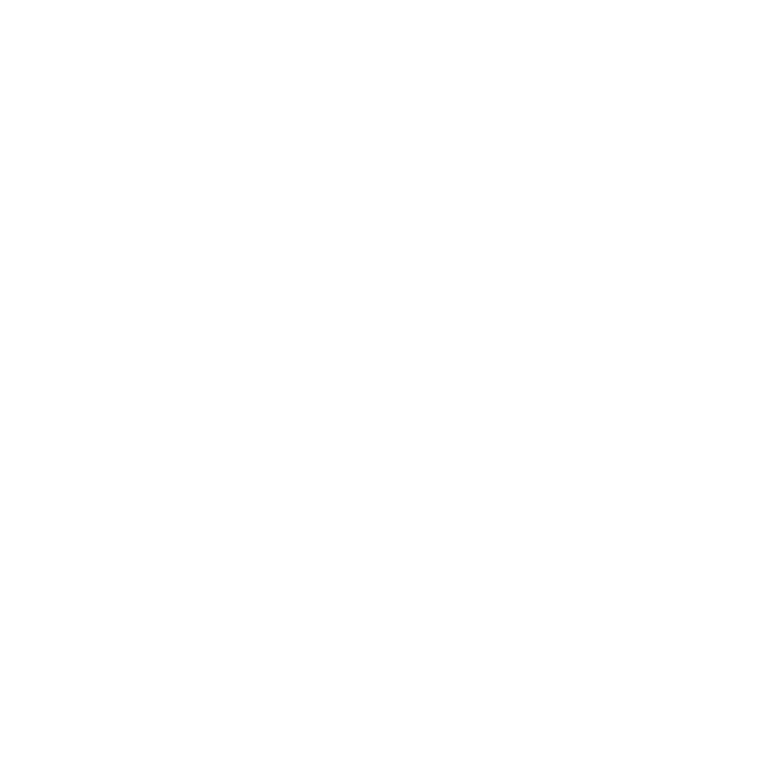

<IPython.core.display.Javascript object>


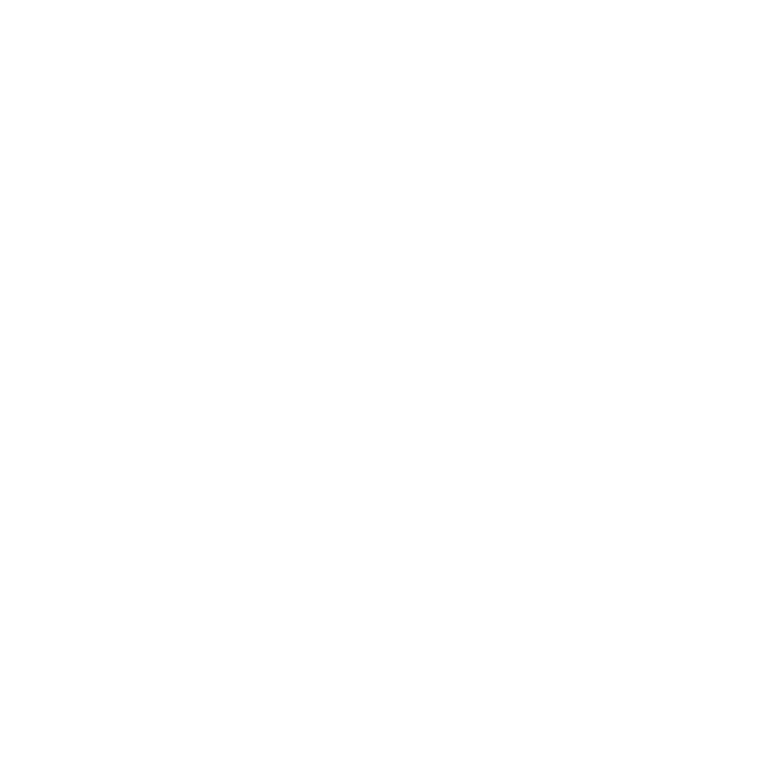

In [9]:
plt.figure(figsize=(7,7))
plt.imshow(image)
plt.scatter(skel.critical_point.loc[skel.filament.loc[0].cp1]['x'],
            skel.critical_point.loc[skel.filament.loc[0].cp1]['y'],
            color='red', s=2)
plt.scatter(skel.critical_point.loc[skel.filament.loc[0].cp2]['x'],
            skel.critical_point.loc[skel.filament.loc[0].cp2]['y'],
            color='red', s=2)

plt.figure(figsize=(7,7))
plt.imshow(image)
plt.scatter(skel.point[skel.point['filament']==0]['x'],
            skel.point[skel.point['filament']==0]['y'],
            color='red', s=2)
    
    

In [10]:
skel.specs = specs
mask_inv = skel.create_binary_image()

<IPython.core.display.Javascript object>


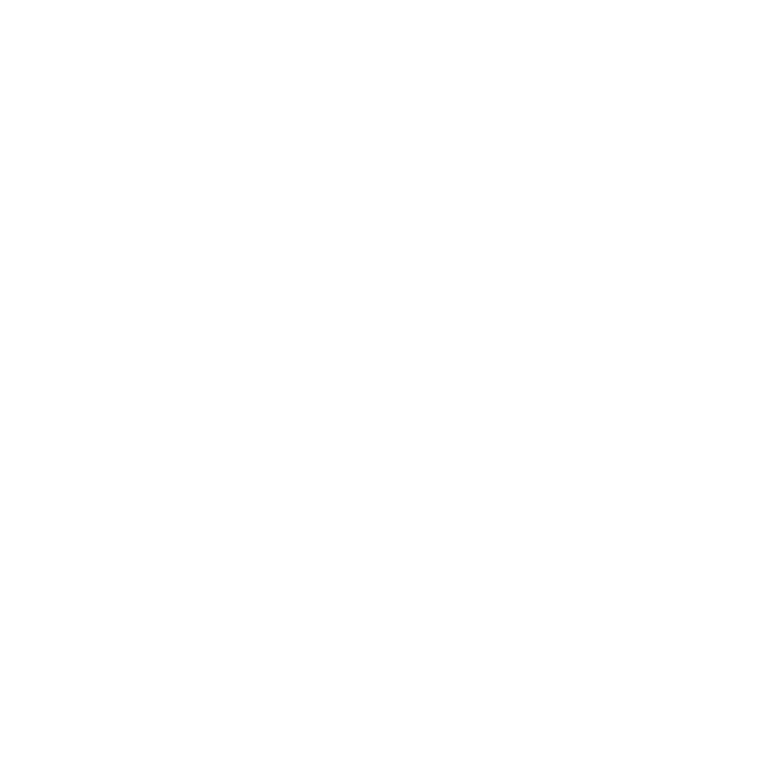

<IPython.core.display.Javascript object>


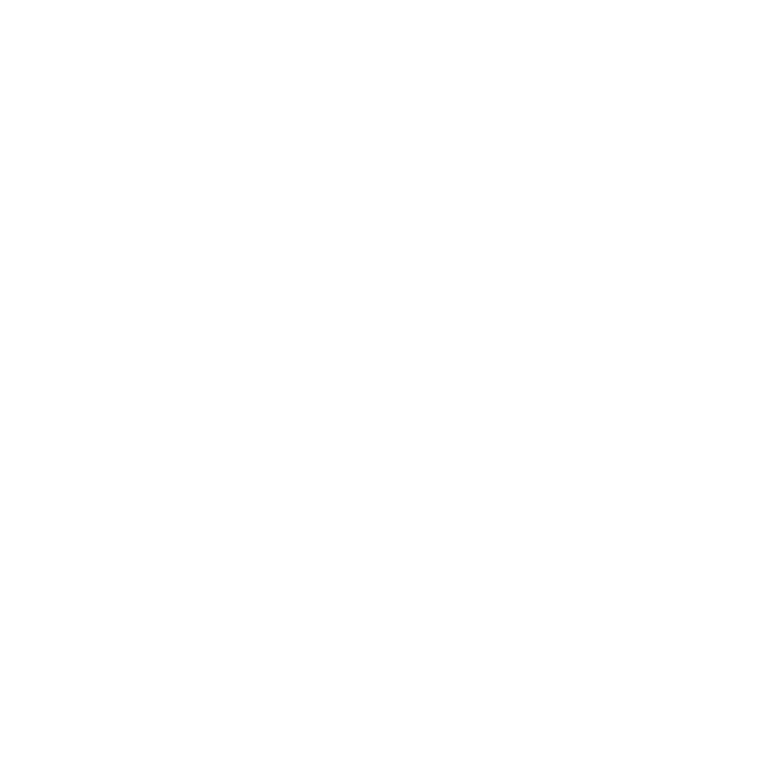

In [11]:
plt.figure(figsize=(7,7))
plt.imshow(mask_inv, origin='lower')
plt.title('mask_inv')
mask_inv = mask_inv.astype(int)

mask = ((~mask_inv.astype(bool)).astype(int))
plt.figure(figsize=(7,7))
plt.imshow(mask, origin='lower')
plt.title('mask')
mask = mask.astype(int)

<IPython.core.display.Javascript object>


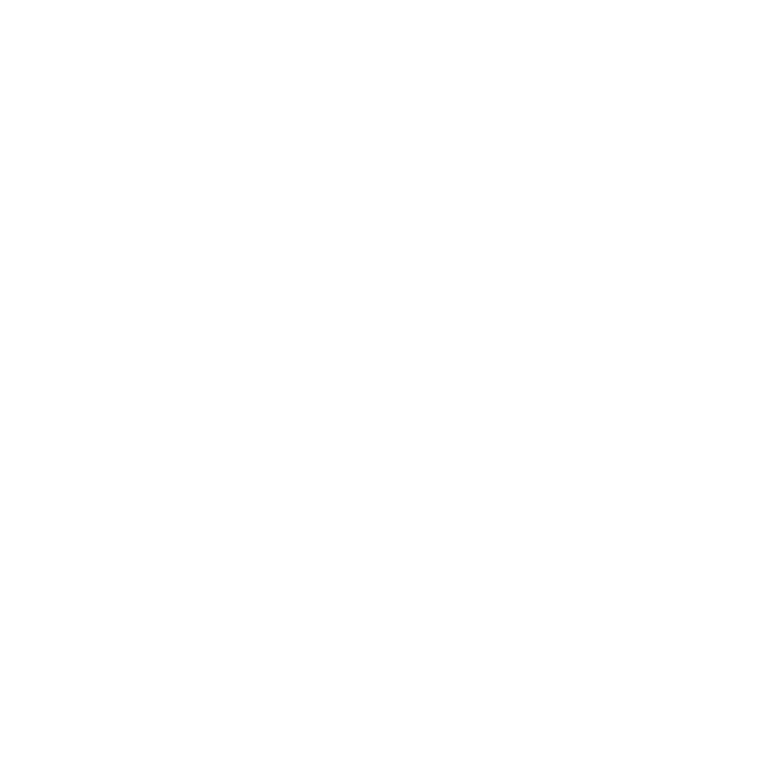

Text(0.5, 1.0, 'mask')

In [12]:
plt.figure(figsize=(7,7))
ax1 = plt.subplot(2,1,1)
ax1.imshow(image, origin='lower')
ax1.set_title('image')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(mask, origin='lower')
ax2.set_title('mask')


<IPython.core.display.Javascript object>


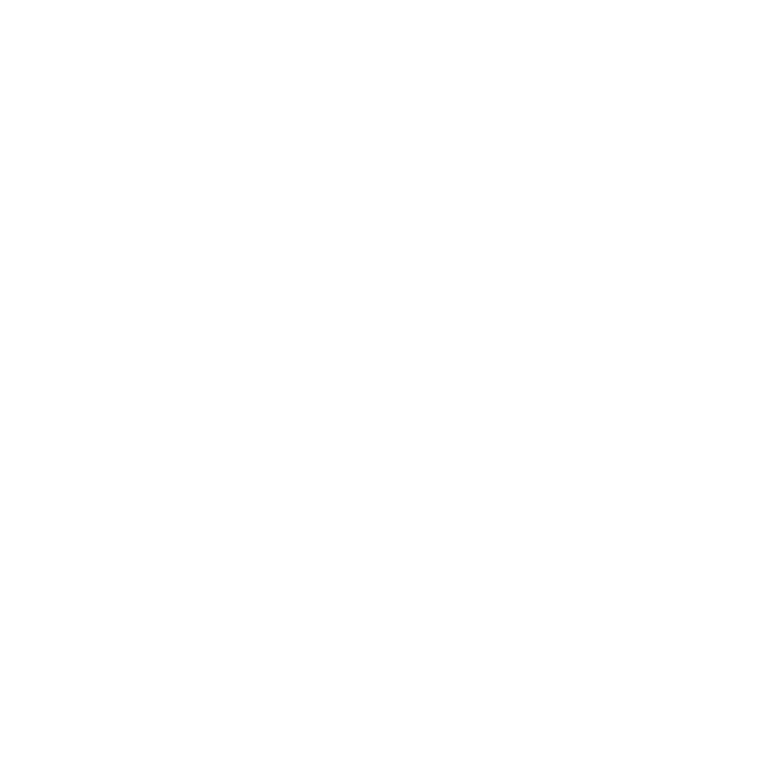

<IPython.core.display.Javascript object>


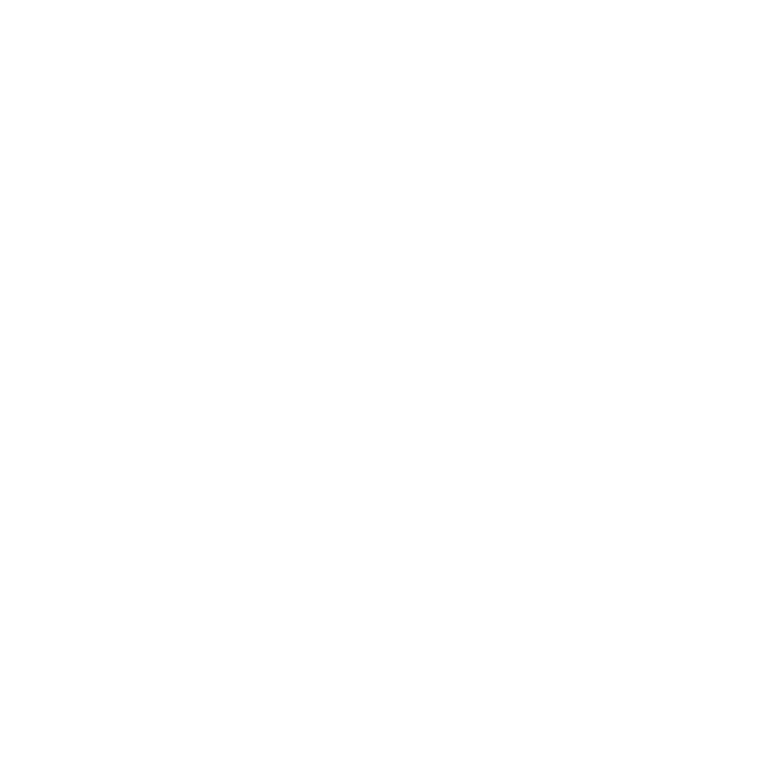

Text(0.5, 1.0, 'mask_inv_dilation')

In [13]:
from Dissects.image import dilation
# elargissement
mask_dilation = dilation(mask, 1)
plt.figure(figsize=(7,7))
plt.imshow(mask_dilation, origin='lower')
plt.title('mask_dilation')

mask_inv_dilation = (~mask_dilation.astype(bool)).astype(int)
plt.figure(figsize=(7,7))
plt.imshow(mask_inv_dilation,origin='lower')
plt.title('mask_inv_dilation')



<IPython.core.display.Javascript object>


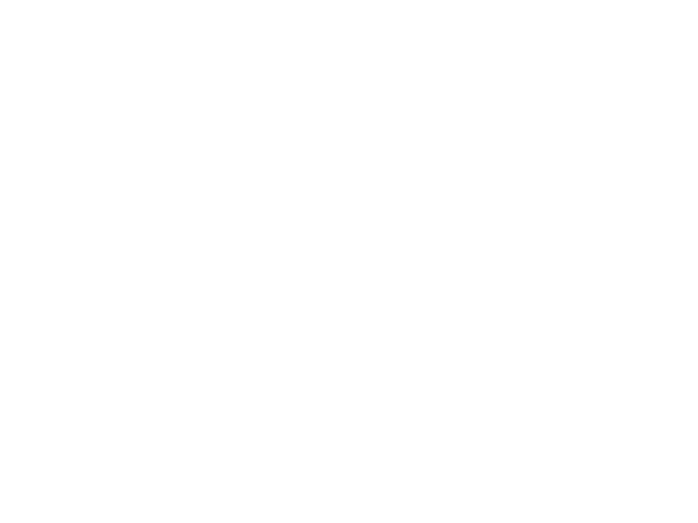

Text(0.5, 1.0, 'Masque Dilation + image original')

In [14]:
fig, ax = plt.subplots()
ax.imshow(image, origin='lower')
y,x = np.where(mask_dilation != 0)
ax.scatter(x,y, alpha=0.2, s=2, color='white')
plt.title('Masque Dilation + image original')

<IPython.core.display.Javascript object>


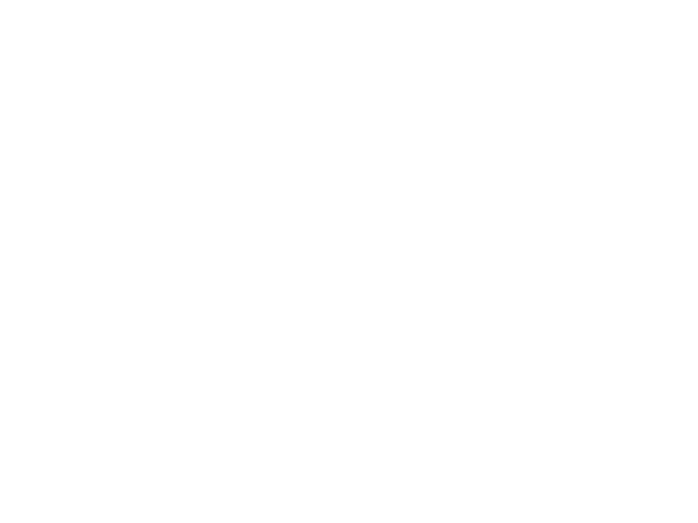

<IPython.core.display.Javascript object>


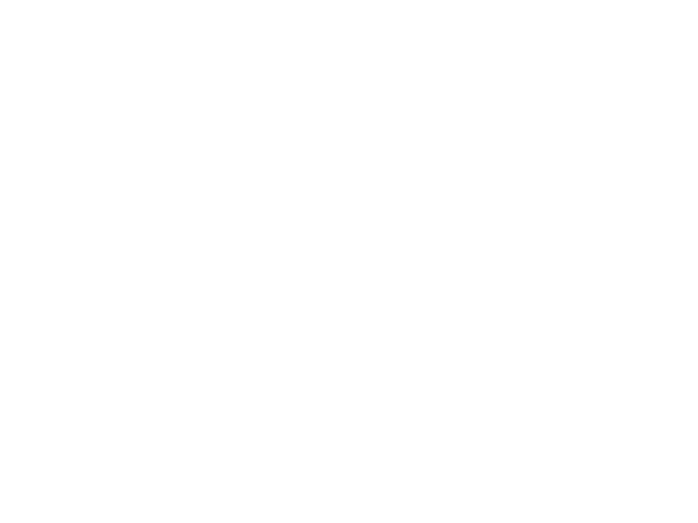

Text(0.5, 1.0, 'Junctional signal')

In [15]:
# Background
plt.figure()
plt.imshow(mask_inv_dilation * image, origin='lower')
plt.title('background signal')


#Junction
plt.figure()
plt.imshow(mask_dilation*image, origin='lower')
plt.title('Junctional signal')


In [16]:
#from Dissects.analysis import general_analysis
print('mean background =',general_analysis(image, mask_dilation)[0], ',',
      'std =', general_analysis(image, mask_dilation)[1])

print('mean junctional signal=',general_analysis(image, mask_dilation)[2], ',',
      'std =', general_analysis(image, mask_dilation)[3])


mean background = 679.6201338418364 , std = 671.7302549690124
mean junctional signal= 5600.43290185754 , std = 3750.4964749497253


In [17]:
%matplotlib notebook

# Segmentation


In [199]:
seg = segmentation(mask, 10)

<IPython.core.display.Javascript object>


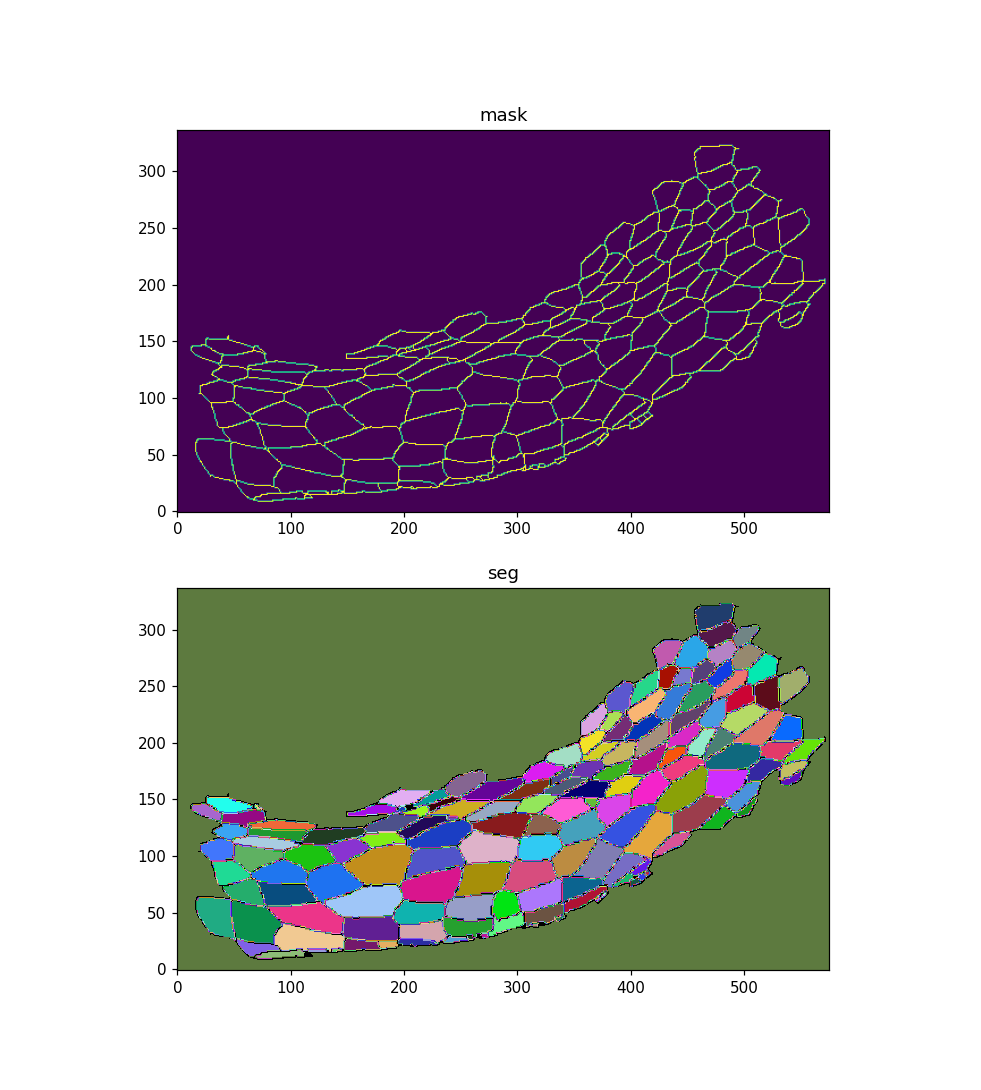

Text(0.5, 1.0, 'seg')

In [99]:
from matplotlib.colors import ListedColormap
rand = np.random.rand(256,3)
rand[0] = 0
cmap_rand = ListedColormap(rand)


plt.figure(figsize=(9,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(mask, origin='lower')
ax1.set_title('mask')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(seg, cmap=cmap_rand, origin='lower')
ax2.set_title('seg')

<IPython.core.display.Javascript object>


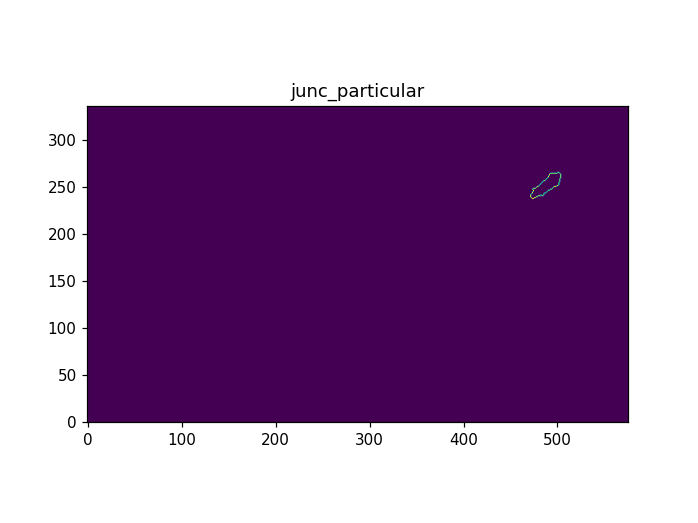

Text(0.5, 1.0, 'junc_particular')

In [100]:
junc_particular = junction_around_cell(mask, seg, 151)

plt.figure()
plt.imshow(junc_particular, origin='lower')
plt.title('junc_particular')

In [102]:
df_alphacat=cellstats(image, mask, 1, seg, 'alpha-cat', 1/pixel_ratio)

In [103]:
df_alphacat

,CellNbr,perimeter_um,areaCell_um2,meanCell_alpha-cat,stdCell_alpha-cat,semCell_alpha-cat,meanJunc_alpha-cat,stdJunc_alpha-cat,semJunc_alpha-cat
0,2.0,16.857261,6.714727,2325.550000,1758.058278,176.691505,7165.116129,4402.412673,250.444507
1,3.0,15.208181,9.400617,1260.055866,987.009273,73.979473,4935.668874,3419.218266,197.080464
2,5.0,6.413088,1.040783,NaN,NaN,NaN,6664.771930,4149.585752,390.360191
3,6.0,27.667895,33.707928,1378.391990,1232.943285,42.977701,6103.937381,4188.436616,182.624515
4,7.0,3.481391,0.436457,NaN,NaN,NaN,6092.621212,2816.138065,349.298937
...,...,...,...,...,...,...,...,...,...
145,159.0,15.208181,18.633367,1059.083710,326.265188,15.536438,6273.822086,4406.117504,244.407424
146,160.0,12.093252,11.347888,1239.024490,743.871658,47.621503,7830.208955,4412.621545,270.048053
147,161.0,11.177097,8.561277,1220.341040,459.630292,35.046481,7393.537190,3866.206012,249.044222
148,162.0,14.658487,14.235221,1105.221519,575.278855,32.413291,6351.563694,3839.969293,217.047897


# Attempt n2 vertices


<IPython.core.display.Javascript object>


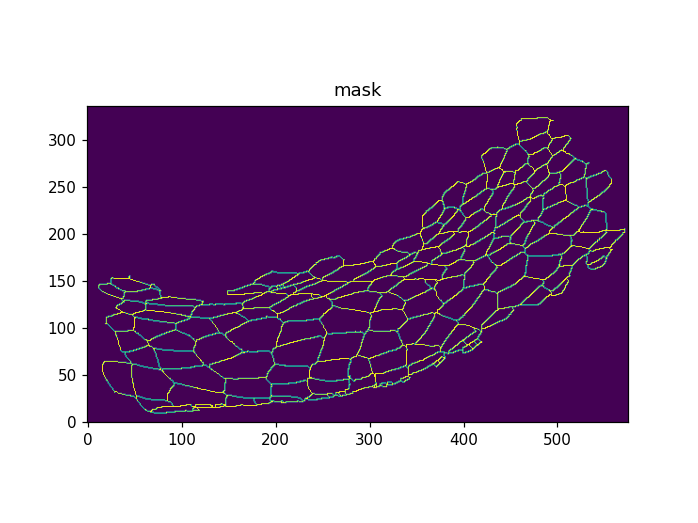

Text(0.5, 1.0, 'mask')

In [474]:
plt.figure()
plt.imshow(mask, origin='lower')
plt.title('mask')

In [475]:
mask_int = mask.astype(np.uint16)
erosion = cv2.erode(mask_int, kernel, iterations = 1)
new_mask = mask - erosion



<IPython.core.display.Javascript object>


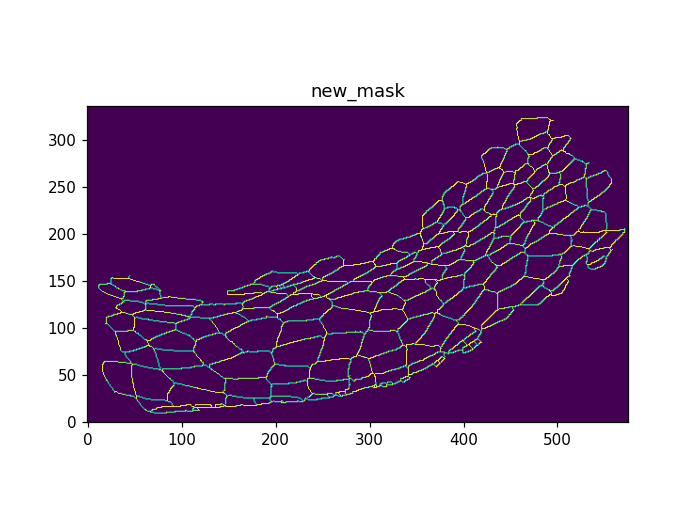

Text(0.5, 1.0, 'new_mask')

In [476]:
plt.figure()
plt.imshow(new_mask, origin='lower')
plt.title('new_mask')

<IPython.core.display.Javascript object>


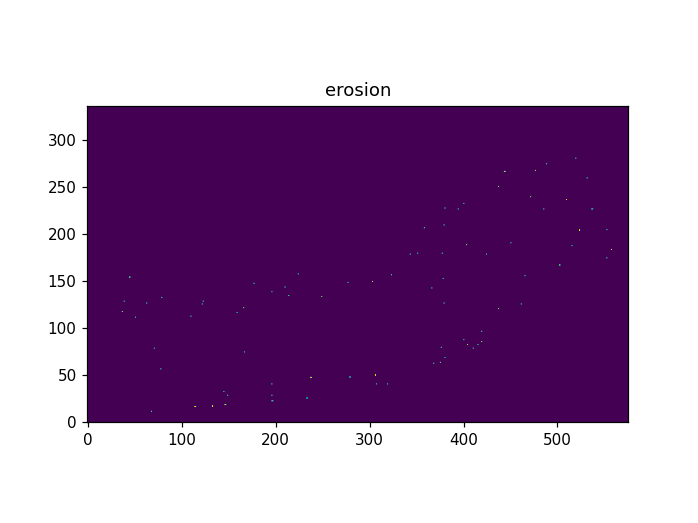

Text(0.5, 1.0, 'erosion')

In [477]:


plt.figure()
plt.imshow(erosion, origin='lower')
plt.title('erosion')

<IPython.core.display.Javascript object>


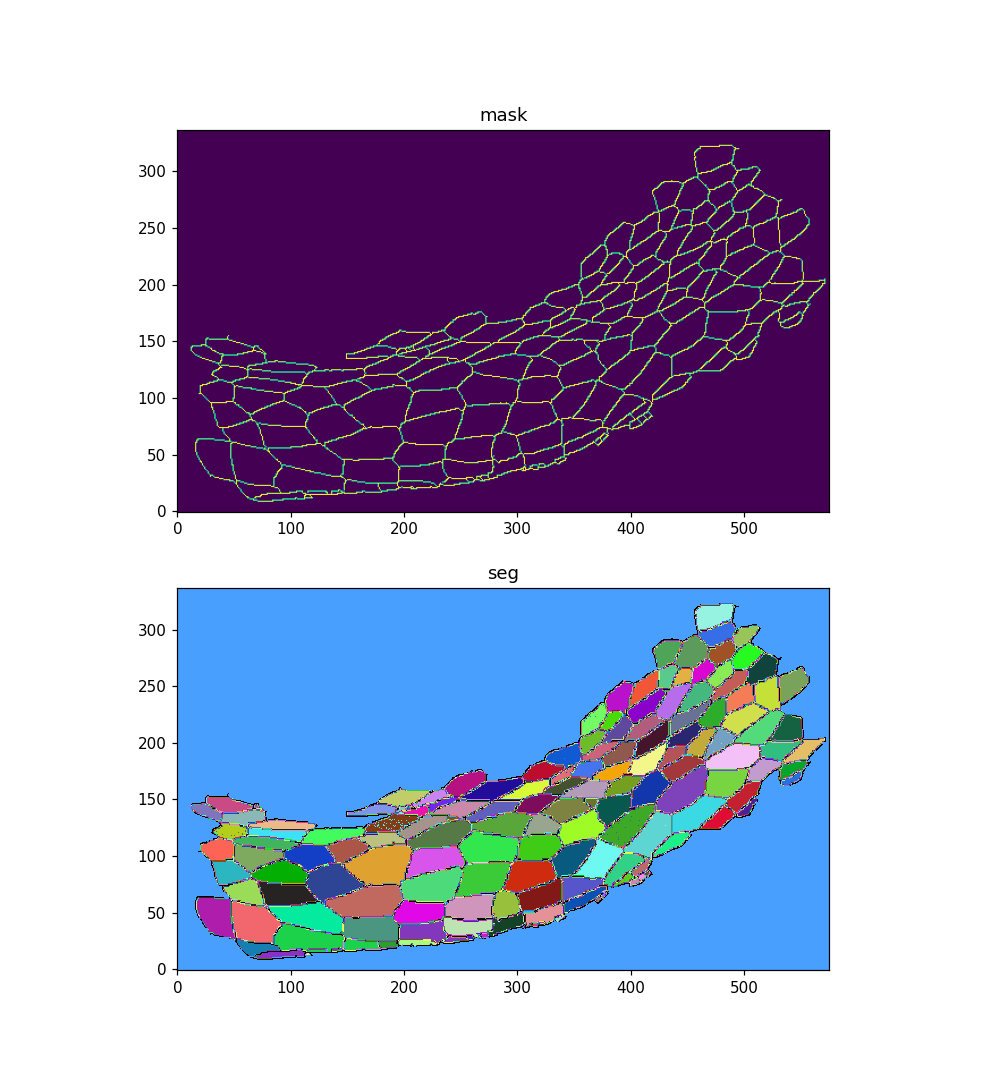

Text(0.5, 1.0, 'seg')

In [481]:
seg2 = segmentation(new_mask, 0)

from matplotlib.colors import ListedColormap
rand = np.random.rand(256,3)
rand[0] = 0
cmap_rand = ListedColormap(rand)


plt.figure(figsize=(9,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(mask_erode, origin='lower')
ax1.set_title('mask')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(seg2, cmap=cmap_rand, origin='lower')
ax2.set_title('seg')

In [482]:
image_final = np.zeros_like(mask)

for i in range(1, np.unique(seg)[-1]):
    
    
    image_cell_mask_i = np.zeros_like(mask)
    image_cell_mask_i[np.where(seg2 == i)] = 1
    seg_dilate_i = dilation(image_cell_mask_i, 1)
    
    
    image_final = image_final + seg_dilate_i
    

    
    

<IPython.core.display.Javascript object>


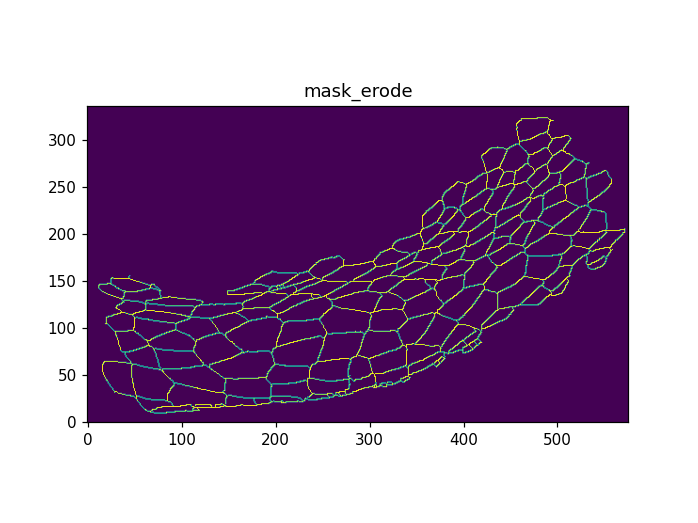

<IPython.core.display.Javascript object>


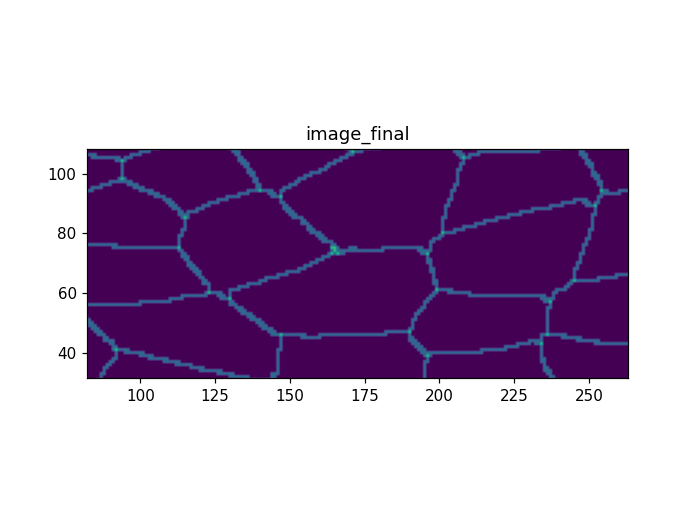

Text(0.5, 1.0, 'image_final')

In [483]:
plt.figure()
plt.imshow(mask_erode, origin='lower')
plt.title('mask_erode')

plt.figure()
plt.imshow(image_final, origin='lower')
plt.title('image_final')

In [484]:
#Dataframe

In [485]:
np.where(image_final==3)

(array([ 11,  12,  15,  15,  15,  16,  17,  18,  20,  21,  21,  22,  22,
         25,  25,  25,  26,  27,  27,  27,  28,  28,  29,  29,  31,  31,
         32,  36,  37,  37,  38,  38,  39,  39,  39,  40,  40,  41,  41,
         43,  43,  45,  46,  46,  46,  47,  48,  50,  50,  51,  51,  54,
         55,  57,  57,  58,  59,  60,  61,  61,  61,  61,  62,  62,  64,
         65,  66,  67,  68,  71,  73,  73,  73,  73,  73,  74,  74,  74,
         75,  75,  75,  76,  77,  77,  79,  80,  80,  80,  81,  81,  81,
         81,  82,  82,  85,  85,  86,  86,  88,  89,  92,  93,  94,  94,
         96,  96,  96,  97,  97,  98,  98,  99,  99, 103, 104, 105, 107,
        108, 109, 109, 110, 110, 110, 111, 111, 112, 112, 114, 115, 115,
        115, 116, 116, 116, 117, 119, 119, 119, 120, 121, 121, 122, 123,
        124, 124, 125, 125, 128, 129, 129, 130, 131, 131, 131, 132, 133,
        134, 135, 135, 136, 136, 136, 137, 138, 138, 138, 138, 139, 139,
        139, 139, 140, 140, 141, 141, 141, 141, 141

In [486]:
vertices = np.where(image_final==3)

In [487]:
vertices[0]

array([ 11,  12,  15,  15,  15,  16,  17,  18,  20,  21,  21,  22,  22,
        25,  25,  25,  26,  27,  27,  27,  28,  28,  29,  29,  31,  31,
        32,  36,  37,  37,  38,  38,  39,  39,  39,  40,  40,  41,  41,
        43,  43,  45,  46,  46,  46,  47,  48,  50,  50,  51,  51,  54,
        55,  57,  57,  58,  59,  60,  61,  61,  61,  61,  62,  62,  64,
        65,  66,  67,  68,  71,  73,  73,  73,  73,  73,  74,  74,  74,
        75,  75,  75,  76,  77,  77,  79,  80,  80,  80,  81,  81,  81,
        81,  82,  82,  85,  85,  86,  86,  88,  89,  92,  93,  94,  94,
        96,  96,  96,  97,  97,  98,  98,  99,  99, 103, 104, 105, 107,
       108, 109, 109, 110, 110, 110, 111, 111, 112, 112, 114, 115, 115,
       115, 116, 116, 116, 117, 119, 119, 119, 120, 121, 121, 122, 123,
       124, 124, 125, 125, 128, 129, 129, 130, 131, 131, 131, 132, 133,
       134, 135, 135, 136, 136, 136, 137, 138, 138, 138, 138, 139, 139,
       139, 139, 140, 140, 141, 141, 141, 141, 141, 142, 142, 14

<IPython.core.display.Javascript object>


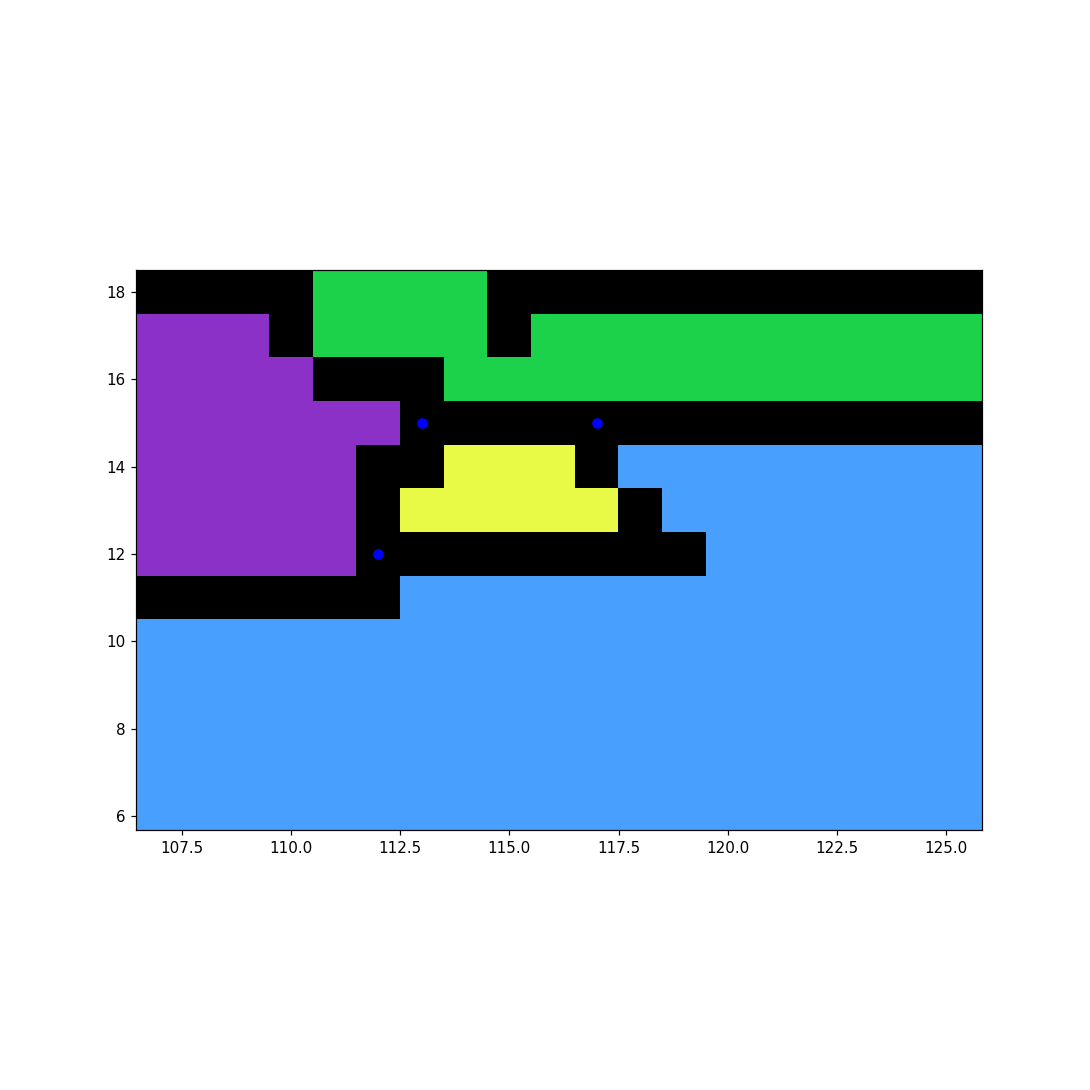

In [499]:
plt.figure(figsize=(10,10))
#plt.imshow(seg, origin='lower',cmap='gist_gray')
plt.imshow(seg2, cmap=cmap_rand, origin='lower')
ax.set_aspect('equal')
plt.scatter(vertices[1], vertices[0], color='b')

In [592]:
columns_name = ['x_0',
                'y_0',
                'Cell_1',
                'Cell_2',
                'Cell_3',
                'Cell_4']
nb_vertices = len(vertices[0])
init = np.zeros((nb_vertices , len(columns_name)))

df_vertices = pd.DataFrame(data=init, columns=columns_name)

for v in range(0, len(vertices[0])-1):
    df_vertices.loc[v]['x_0'] = vertices[0][v]
    df_vertices.loc[v]['y_0'] = vertices[1][v]

    carre=seg2[vertices[0][v]-2 : vertices[0][v]+3, vertices[1][v]-2 : vertices[1][v]+3]
    cells = np.unique(carre)
    
    df_vertices.loc[v]['Cell_1'] = cells[1]
    df_vertices.loc[v]['Cell_2'] = cells[2]
    df_vertices.loc[v]['Cell_3'] = cells[3]
    
    if len(np.unique(carre))==4 :
        df_vertices.loc[v]['Cell_4'] = 'Nan'
    else:
        df_vertices.loc[v]['Cell_4'] = cells[4]


    

In [593]:
df_vertices

,x_0,y_0,Cell_1,Cell_2,Cell_3,Cell_4
0,11.0,67.0,1.0,2.0,3.0,NaN
1,12.0,112.0,1.0,2.0,4.0,NaN
2,15.0,113.0,2.0,4.0,5.0,NaN
3,15.0,117.0,1.0,4.0,5.0,NaN
4,15.0,136.0,1.0,5.0,6.0,NaN
...,...,...,...,...,...,...
321,291.0,489.0,157.0,158.0,159.0,NaN
322,295.0,459.0,1.0,156.0,159.0,NaN
323,298.0,459.0,1.0,159.0,160.0,NaN
324,301.0,494.0,1.0,158.0,159.0,NaN


<IPython.core.display.Javascript object>


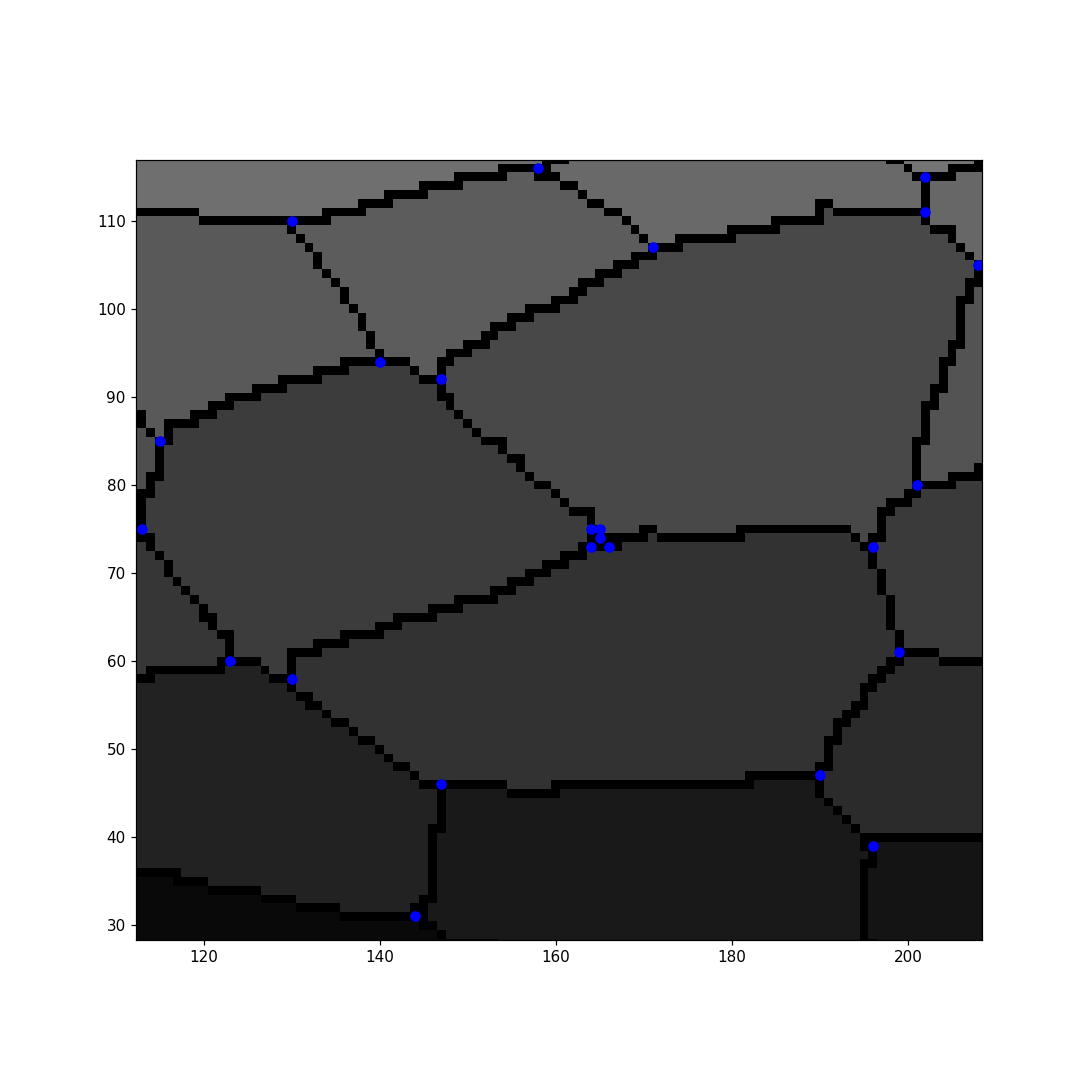

In [594]:
plt.figure(figsize=(10,10))
plt.imshow(seg, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(df_vertices['y_0'], df_vertices['x_0'], color='b')

In [595]:
#
ind = 0
while ind < len(df_vertices) :
    #print(df_vertices.shape[0])
    cells_ind = np.array([df_vertices['Cell_1'].iloc[ind], 
                          df_vertices['Cell_2'].iloc[ind], 
                          df_vertices['Cell_3'].iloc[ind],
                          df_vertices['Cell_4'].iloc[ind]])
    

    liste_x0 = [df_vertices['x_0'].iloc[ind]]
    liste_y0 = [df_vertices['y_0'].iloc[ind]]
    liste_i = []
    
    
    for i in range(ind+1, len(df_vertices)):
        
        cells_i = np.array([df_vertices['Cell_1'].iloc[i],
                            df_vertices['Cell_2'].iloc[i], 
                            df_vertices['Cell_3'].iloc[i],
                            df_vertices['Cell_4'].iloc[i]])
        

        mask_TrueFalse = np.isin(cells_ind, cells_i)
        
        if np.sum(mask_TrueFalse) >= 3 :
            liste_i.append(df_vertices.axes[0][i])
            liste_x0.append(df_vertices['x_0'].iloc[i])
            liste_y0.append(df_vertices['y_0'].iloc[i])
            
    
    df_vertices['x_0'].iloc[ind]=int(np.mean(liste_x0))
    df_vertices['y_0'].iloc[ind]=int(np.mean(liste_y0))
    
    #print(liste_i)
    df_vertices=df_vertices.drop(liste_i)
    
    ind+=1

In [596]:
df_vertices

,x_0,y_0,Cell_1,Cell_2,Cell_3,Cell_4
0,11.0,67.0,1.0,2.0,3.0,NaN
1,12.0,112.0,1.0,2.0,4.0,NaN
2,15.0,113.0,2.0,4.0,5.0,NaN
3,15.0,117.0,1.0,4.0,5.0,NaN
4,16.0,140.0,1.0,5.0,6.0,NaN
...,...,...,...,...,...,...
321,291.0,489.0,157.0,158.0,159.0,NaN
322,295.0,459.0,1.0,156.0,159.0,NaN
323,298.0,459.0,1.0,159.0,160.0,NaN
324,301.0,494.0,1.0,158.0,159.0,NaN


<IPython.core.display.Javascript object>


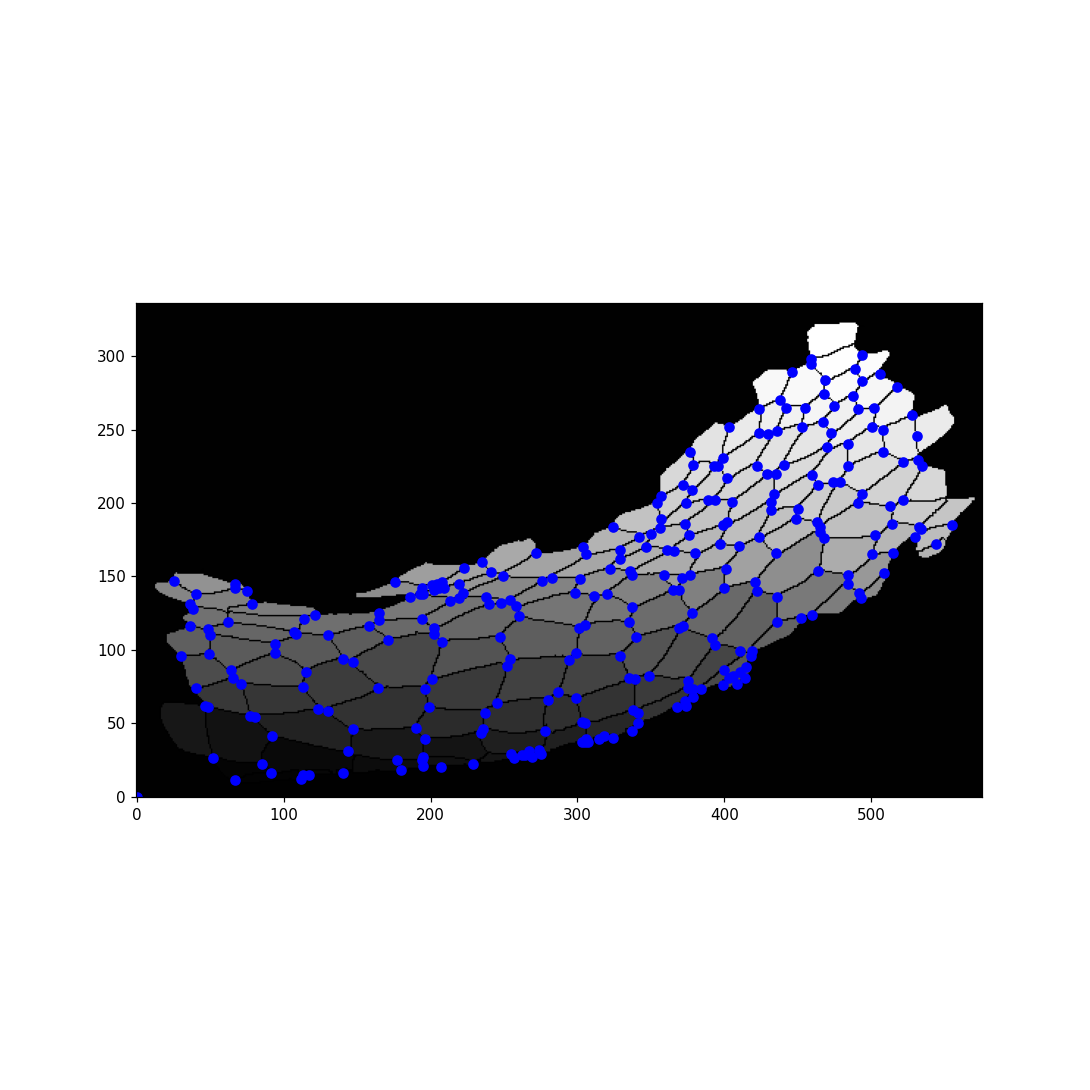

In [597]:
plt.figure(figsize=(10,10))
plt.imshow(seg, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(df_vertices['y_0'], df_vertices['x_0'], color='b')

In [599]:
df_vertices

,x_0,y_0,Cell_1,Cell_2,Cell_3,Cell_4
0,11.0,67.0,1.0,2.0,3.0,NaN
1,12.0,112.0,1.0,2.0,4.0,NaN
2,15.0,113.0,2.0,4.0,5.0,NaN
3,15.0,117.0,1.0,4.0,5.0,NaN
4,16.0,140.0,1.0,5.0,6.0,NaN
...,...,...,...,...,...,...
321,291.0,489.0,157.0,158.0,159.0,NaN
322,295.0,459.0,1.0,156.0,159.0,NaN
323,298.0,459.0,1.0,159.0,160.0,NaN
324,301.0,494.0,1.0,158.0,159.0,NaN


In [602]:
columns_name = ['x_0',
                'y_0',
                'Cell_1',
                'Cell_2',
                'Cell_3',
                'Cell_4']
nb_vertices = len(vertices[0])
init = df_vertices.to_numpy()

df_vertices2 = pd.DataFrame(data=init, columns=columns_name)



In [603]:
df_vertices2

,x_0,y_0,Cell_1,Cell_2,Cell_3,Cell_4
0,11.0,67.0,1.0,2.0,3.0,NaN
1,12.0,112.0,1.0,2.0,4.0,NaN
2,15.0,113.0,2.0,4.0,5.0,NaN
3,15.0,117.0,1.0,4.0,5.0,NaN
4,16.0,140.0,1.0,5.0,6.0,NaN
...,...,...,...,...,...,...
285,291.0,489.0,157.0,158.0,159.0,NaN
286,295.0,459.0,1.0,156.0,159.0,NaN
287,298.0,459.0,1.0,159.0,160.0,NaN
288,301.0,494.0,1.0,158.0,159.0,NaN


In [605]:
#Création d'un DataFrame
init = np.zeros((1,7))
df4_jonctions = pd.DataFrame(columns=['Cell1','Cell2','x0','y0',
                                       'x1','y1',
                                       'angle'])


for ind in range (0,df_vertices2.shape[0]): #pour chaque vertex
    print(ind)
    
    if np.isnan(df_vertices2['Cell_4'][ind]):
        
        cells_ind = np.array([df_vertices2['Cell_1'][ind], df_vertices2['Cell_2'][ind], 
                          df_vertices2['Cell_3'][ind]])
        for i in range (ind, df_vertices2.shape[0]): # pour chaque autre vertex
    
    
            cells_i = np.array([df_vertices2['Cell_1'][i], df_vertices2['Cell_2'][i], 
                            df_vertices2['Cell_3'][i], df_vertices2['Cell_4'][i]])
        
            mask_TrueFalse = np.isin(cells_ind, cells_i)
            if np.sum(mask_TrueFalse) == 2 :
   
    
                dict_jonctions={'Cell1': cells_ind[np.where(mask_TrueFalse)][0],
                    'Cell2': cells_ind[np.where(mask_TrueFalse)][1],
                    'x0' : df_vertices2['x_0'][i],
                    'y0' : df_vertices2['y_0'][i],
                    'x1' : df_vertices2['x_0'][ind],
                    'y1' : df_vertices2['y_0'][ind],
                    'angle' : np.arctan(
        (df_vertices2['y_0'][ind]-df_vertices2['y_0'][i])
        /(df_vertices2['x_0'][ind]-df_vertices2['x_0'][i])
    )
                   
                   }

                df4_jonctions=df4_jonctions.append(dict_jonctions, ignore_index = True)
            
            
    
    
    
    
        
    else:
    
        cells_ind = np.array([df_vertices2['Cell_1'][ind], df_vertices2['Cell_2'][ind], 
                          df_vertices2['Cell_3'][ind],df_vertices2['Cell_4'][ind]])
        
        for i in range (0,df_vertices2.shape[0]): # pour chaque autre vertex
    
    
            cells_i = np.array([df_vertices2['Cell_1'][i], df_vertices2['Cell_2'][i], 
                            df_vertices2['Cell_3'][i],df_vertices2['Cell_4'][i]])
        
            mask_TrueFalse = np.isin(cells_ind, cells_i)
            if np.sum(mask_TrueFalse) == 3 :
   
    
                dict_jonctions={'Cell1': cells_ind[np.where(mask_TrueFalse)][0],
                    'Cell2': cells_ind[np.where(mask_TrueFalse)][1],
                    'x0' : df_vertices2['x_0'][i],
                    'y0' : df_vertices2['y_0'][i],
                    'x1' : df_vertices2['x_0'][ind],
                    'y1' : df_vertices2['y_0'][ind],
                    'angle' : np.arctan(
        (df_vertices2['y_0'][ind]-df_vertices2['y_0'][i])
        /(df_vertices2['x_0'][ind]-df_vertices2['x_0'][i])
    )
                   
                   }

                df4_jonctions=df4_jonctions.append(dict_jonctions, ignore_index = True)





0
1
2
3
4
5


/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars


6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
28

In [606]:
df4_jonctions

,Cell1,Cell2,x0,y0,x1,y1,angle
0,1.0,2.0,12.0,112.0,11.0,67.0,1.548578
1,2.0,3.0,16.0,91.0,11.0,67.0,1.365401
2,1.0,3.0,26.0,52.0,11.0,67.0,-0.785398
3,2.0,4.0,15.0,113.0,12.0,112.0,0.321751
4,1.0,4.0,15.0,117.0,12.0,112.0,1.030377
...,...,...,...,...,...,...,...
419,1.0,156.0,295.0,459.0,289.0,446.0,1.138389
420,158.0,159.0,301.0,494.0,291.0,489.0,0.463648
421,1.0,159.0,298.0,459.0,295.0,459.0,-0.000000
422,1.0,159.0,301.0,494.0,295.0,459.0,1.401018


<IPython.core.display.Javascript object>


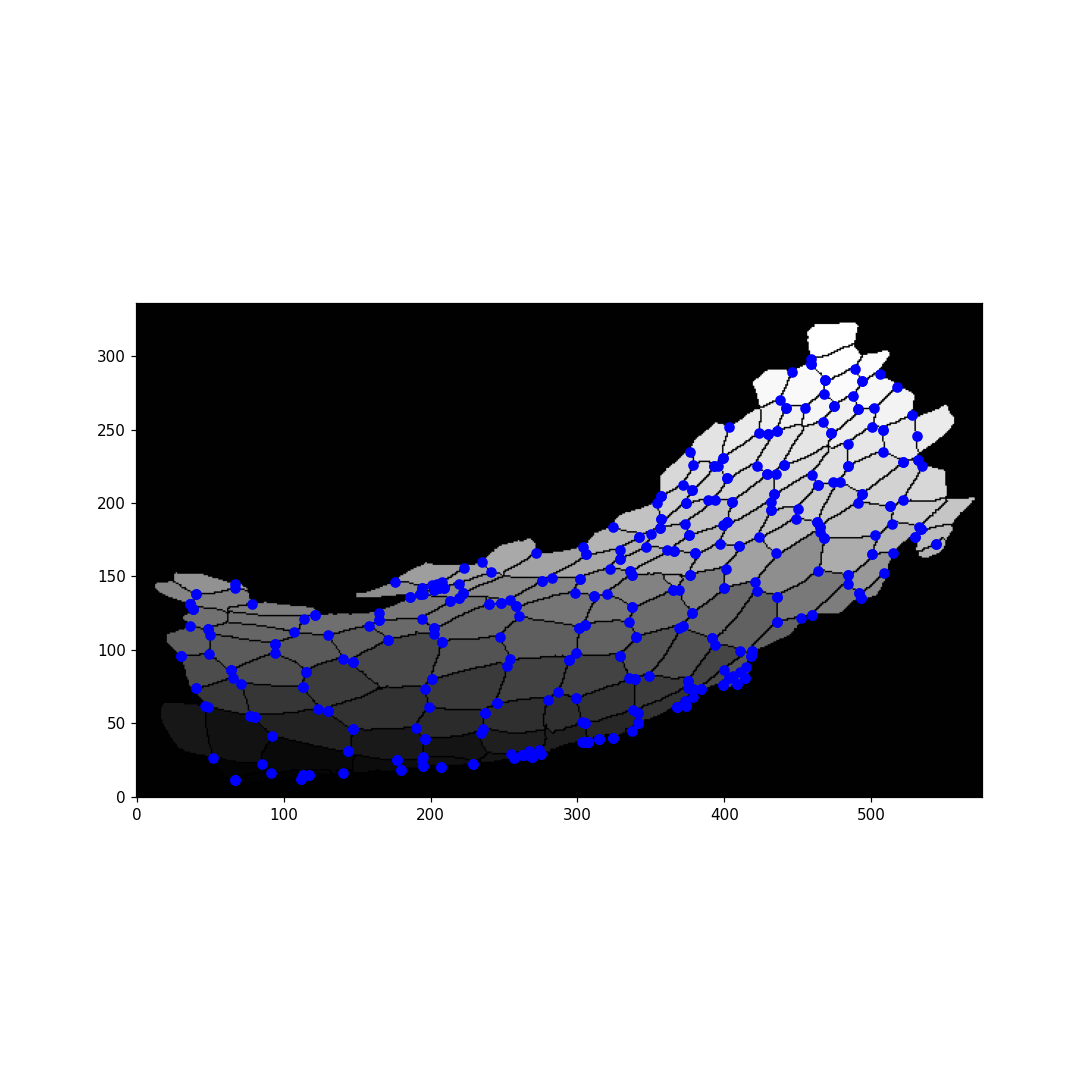

In [607]:
plt.figure(figsize=(10,10))
plt.imshow(seg, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(df4_jonctions['y1'], df4_jonctions['x1'], color='b')

<IPython.core.display.Javascript object>


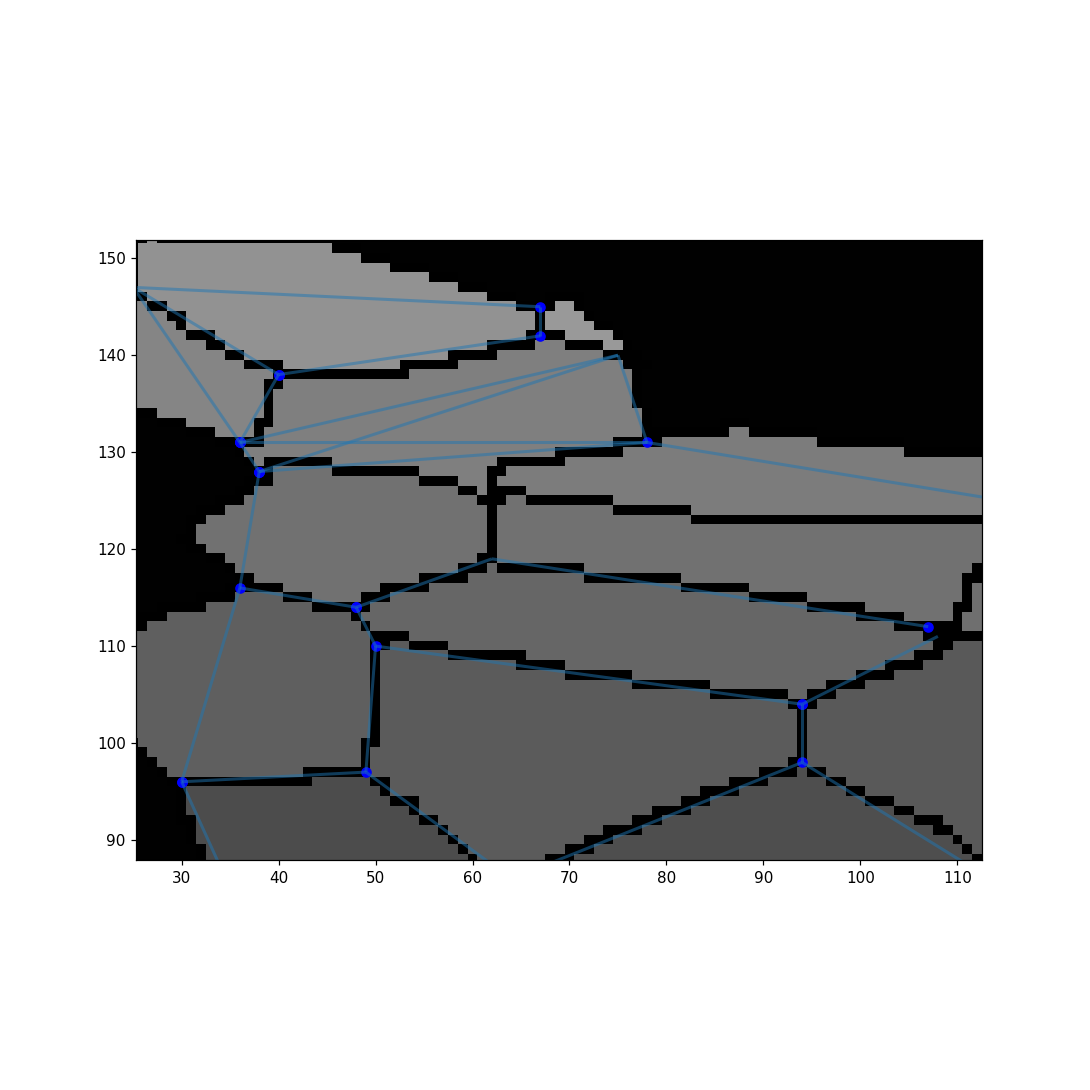

In [608]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

lines=[]
for i in range (0, df4_jonctions.shape[0]) :
    lines.append(([(df4_jonctions['y0'][i],df4_jonctions['x0'][i]),
                   (df4_jonctions['y1'][i],df4_jonctions['x1'][i])]))



cc = df4_jonctions['x0']
lc = mc.LineCollection(lines, cc, cmap='plasma_r', linewidth=2, alpha=0.5)

fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
#ax.autoscale()
#ax.margins(0.1)
#ax.scatter(x,y,color='r', zorder=10, s = 7)
ax.set_aspect('equal')

#plt.imshow(image, origin='lower')

plt.imshow(seg, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(df4_jonctions['y1'], df4_jonctions['x1'], color='b')

# Vertices


In [133]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [105]:
##########
nbCell = len(df_alphacat)
N = 2
##########


#Création d'un dictionnaire contenant les jonctions du périmètre d'une cellule i (key = i ; value = array)
junction_around_cell_dict = {}



import cv2

for i in range (0, nbCell):
    junction_around_cell_dict[i]=junction_around_cell(mask, seg, i)
                          


<IPython.core.display.Javascript object>


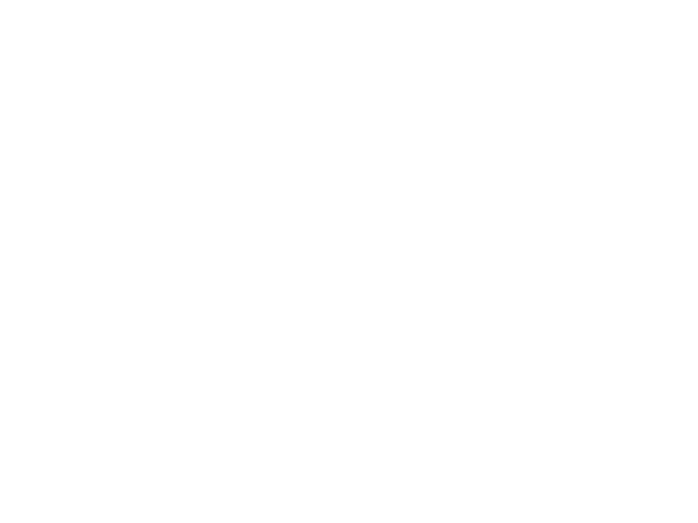

Text(0.5, 1.0, 'junc_particular')

In [106]:

plt.figure()
plt.imshow(junction_around_cell_dict[3], origin='lower')
plt.title('junc_particular')

In [107]:
from scipy import stats as sc

#Création de 2 listes contenant les indices i des périmètres des cellules à comparer
a = []
b = []

for i in range (2, nbCell):
    for j in range (i+1, nbCell):
        a.append(i)
        b.append(j)  


#Création d'un dictionnaire ne contenant que le produit non nul 
#du périmètre de 2 cellules différentes (key = a,b ; value = array)

shared_junction_dict = {}



for i in range(0, len(a)):
    if np.array_equal(junction_around_cell_dict[a[i]]*junction_around_cell_dict[b[i]], np.zeros_like(seg)) == False :
        shared_junction_dict[a[i], b[i]]=junction_around_cell_dict[a[i]]*junction_around_cell_dict[b[i]]


#Récupération des indices des cellules ayant une jonction en commun
m = []
n = []

for k in shared_junction_dict.keys():
    m.append(k[0])
    n.append(k[1])
        
#Création d'un DataFrame
init = np.zeros((len(shared_junction_dict), 6))
df1 = pd.DataFrame(data=init, columns=['cellule a','cellule b','longueur','meanJunc','stdJunc','semJunc'])    
    
for ind,i in enumerate (shared_junction_dict.keys()):
    
    shared_junction_dict_dilated = dilation(shared_junction_dict[i], 1)
    shared_junction_dict_dilated[np.where(shared_junction_dict_dilated != 0)] = 1
    
    df1['cellule a'][ind] = m[ind]
    df1['cellule b'][ind] = n[ind]
    df1['longueur'][ind] = len(np.where(shared_junction_dict[i] == 1)[0])
    df1['meanJunc'][ind] = np.mean(image[np.where(shared_junction_dict_dilated != 0)])
    df1['stdJunc'][ind] = np.std(image[np.where(shared_junction_dict_dilated != 0)])
    df1['semJunc'][ind] = sc.stats.sem(image[np.where(shared_junction_dict_dilated != 0)])

In [108]:
df1

,cellule a,cellule b,longueur,meanJunc,stdJunc,semJunc
0,2.0,3.0,18.0,6732.528571,4565.703234,549.646079
1,2.0,6.0,19.0,11427.720000,3659.169788,425.369848
2,3.0,6.0,8.0,6797.447368,4952.448170,814.177464
3,3.0,12.0,32.0,3441.428571,1758.921635,166.949453
4,3.0,15.0,1.0,6934.000000,1436.530775,507.890326
...,...,...,...,...,...,...
317,143.0,145.0,3.0,7780.466667,3644.221561,973.959180
318,143.0,149.0,8.0,7262.000000,3328.262709,400.675745
319,144.0,146.0,12.0,8196.439024,5030.404620,558.933847
320,145.0,149.0,15.0,7729.029851,4872.584453,599.773685


In [109]:
shared_junction_dict

{(2,
  3): array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 (2,
  6): array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 (3,
  6): array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 (3,
  12): array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 (3,
  15): array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0

<IPython.core.display.Javascript object>


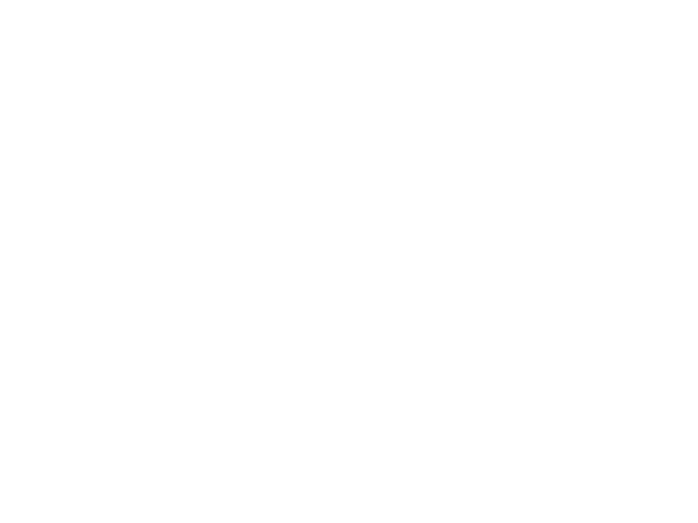

Text(0.5, 1.0, 'Shared Junction between Cell 12 and Cell 36')

In [110]:
plt.figure()
plt.imshow(shared_junction_dict[12,36], origin='lower')
plt.title('Shared Junction between Cell 12 and Cell 36')

In [111]:
df1_Cell2 = df1['cellule a'] == 2

In [112]:
df1_Cell2 

0       True
1       True
2      False
3      False
4      False
       ...  
317    False
318    False
319    False
320    False
321    False
Name: cellule a, Length: 322, dtype: bool

In [131]:

##########
seg2 = np.copy(seg)
x_max = np.shape(seg2)[1]
y_max = np.shape(seg2)[0]
##########


#Création d'un dictionnaire contenant les pixels ayant autour d'eux (dans un rayon de 2 pixels) 
#au moins 3 pixels possédant une valeur différente (key = x,y ; value = numéros cellules)
vertex_dict1 = {}

for x in range (0,x_max):
    for y in range (0,y_max):
        if seg2[y,x] == 0 :
            comp = [0]
            for a in range (x-2, x+2):
                for b in range (y-2, y+2):
                    if 0 < a < x_max and 0 < b < y_max :
                        i = 1
                        for k in range (0,len(comp)):
                            if seg2[b,a] == comp[k]:
                                i = 0
                        if i == 1 :
                            comp.append(seg2[b,a])
            if len(comp) >= 4 :
                vertex_dict1[x,y] = comp           

                #Récupération des coordonnées x et y des vertex
x=[]
y=[]

for k in vertex_dict1.keys():
    x.append(k[0])
    y.append(k[1])

<IPython.core.display.Javascript object>


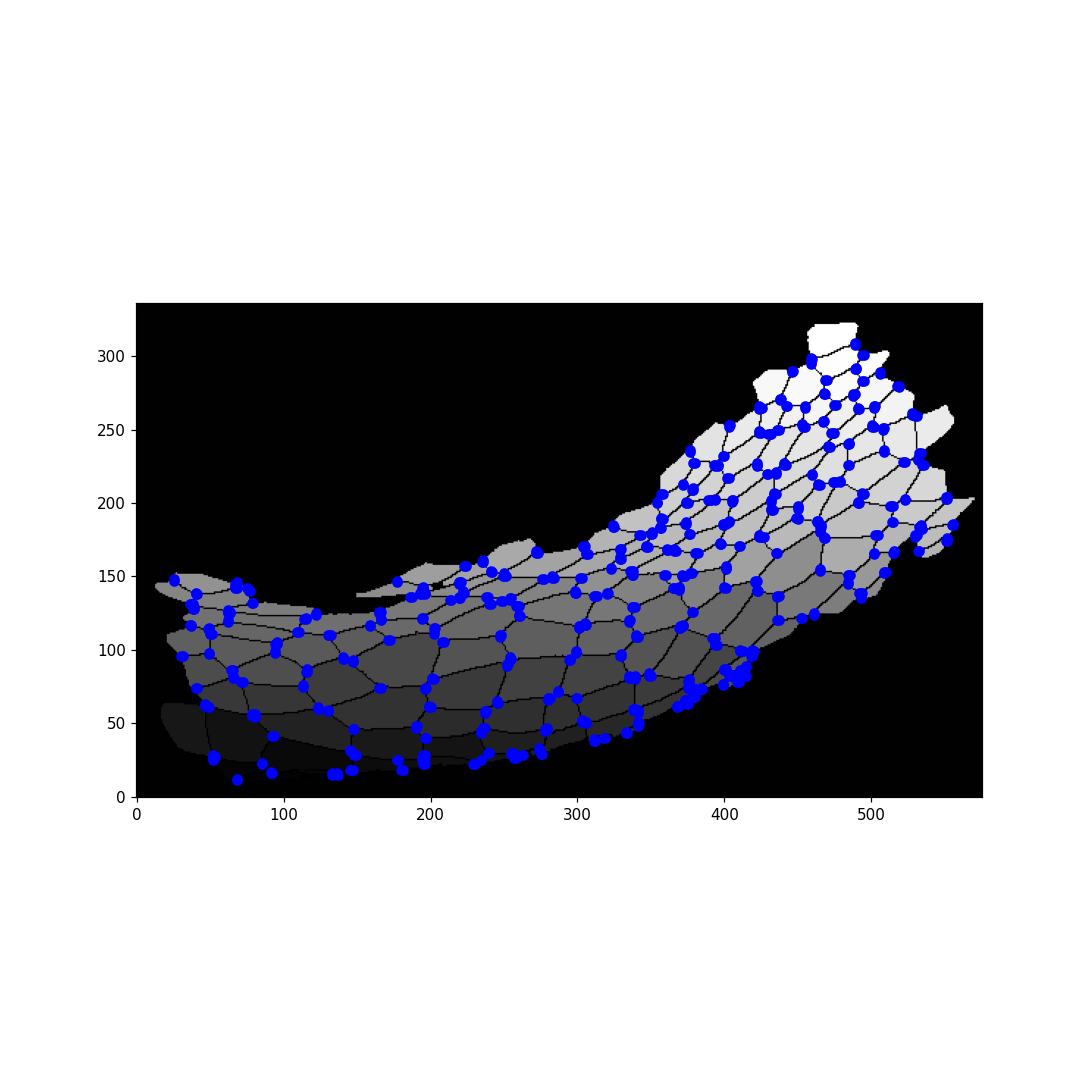

In [132]:
plt.figure(figsize=(10,10))
plt.imshow(seg, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(x, y, color='b')

<IPython.core.display.Javascript object>


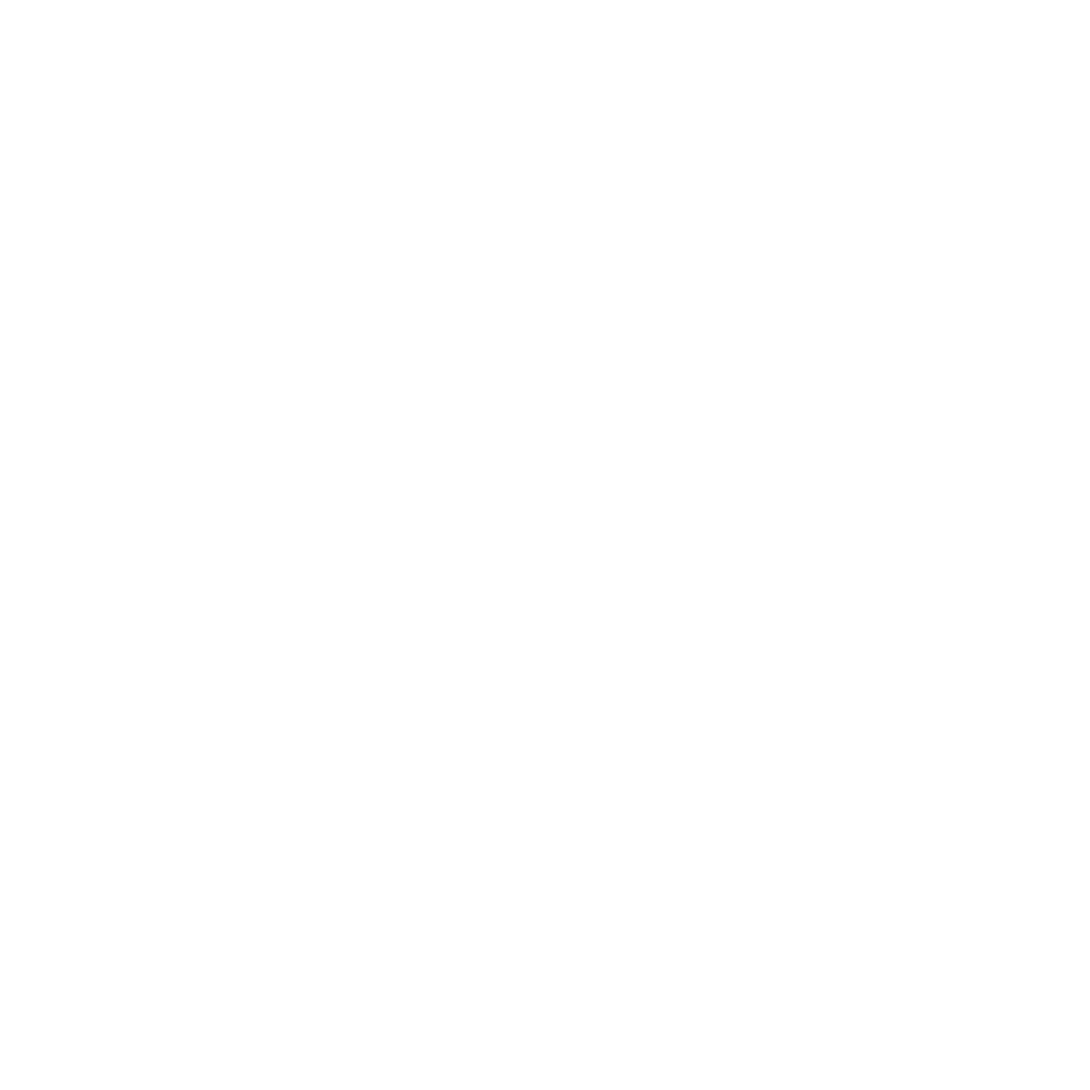

In [115]:
plt.figure(figsize=(10,10))
plt.imshow(mask, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
#plt.scatter(u, v, color='r')
plt.scatter(x, y, color='b')
#plt.scatter(z, t, color='g')

In [116]:
%matplotlib notebook

In [117]:
len(vertex_dict1)

747

In [118]:

#Récupération des numéros de cellules partageant un vertex
m = []
n = []
o = []
p = []

for k in vertex_dict1.values():
    m.append(k[1])
    n.append(k[2])
    o.append(k[3])
    if len(k)>4 :
        p.append(k[4])
    else :
        p.append('Nan')
        


for k in shared_junction_dict.keys():
    m.append(k[0])
    n.append(k[1])

#Création d'un DataFrame
init = np.zeros((len(vertex_dict1), 5))
df2 = pd.DataFrame(data=init, columns=['cellule a','cellule b','cellule c',
                                       'coordonnée x','coordonnée y'])
    
for ind in range (0, len(vertex_dict1)):
    
    df2['cellule a'][ind] = m[ind]
    df2['cellule b'][ind] = n[ind]
    df2['cellule c'][ind] = o[ind]
    df2['coordonnée x'][ind] = x[ind]
    df2['coordonnée y'][ind] = y[ind]

 

In [119]:
# Moyennisation / nettoyage des vertex :

In [120]:
Mounia Lagha #Création d'un dictionnaire contenant les moyennes des coordonnées des vertex voisins (key = x,y ; value = numéros cellules)
vertex_moy = {}

for clé, valeur in vertex_dict1.items() :
    valeur.sort()
    vertex_dict1[clé] = valeur


val_list = []
for i in vertex_dict1.values() :
    if i not in val_list :
        val_list.append(i)
for i in range (0, len(val_list)) :
    key_list = []
    for clé, valeur in vertex_dict1.items() :
        if valeur == val_list[i]:
            key_list.append(clé)

    list_x = []
    list_y = []
    for j in key_list :
        list_x.append(j[0])
        list_y.append(j[1])

    x_moy = round(sum(list_x)/len(list_x))
    y_moy = round(sum(list_y)/len(list_y))

    vertex_moy[x_moy,y_moy] = val_list[i]

#Récupération des coordonnées x et y des vertex
x=[]
y=[]

for k in vertex_moy.keys():
    x.append(k[0])
    y.append(k[1])

<IPython.core.display.Javascript object>


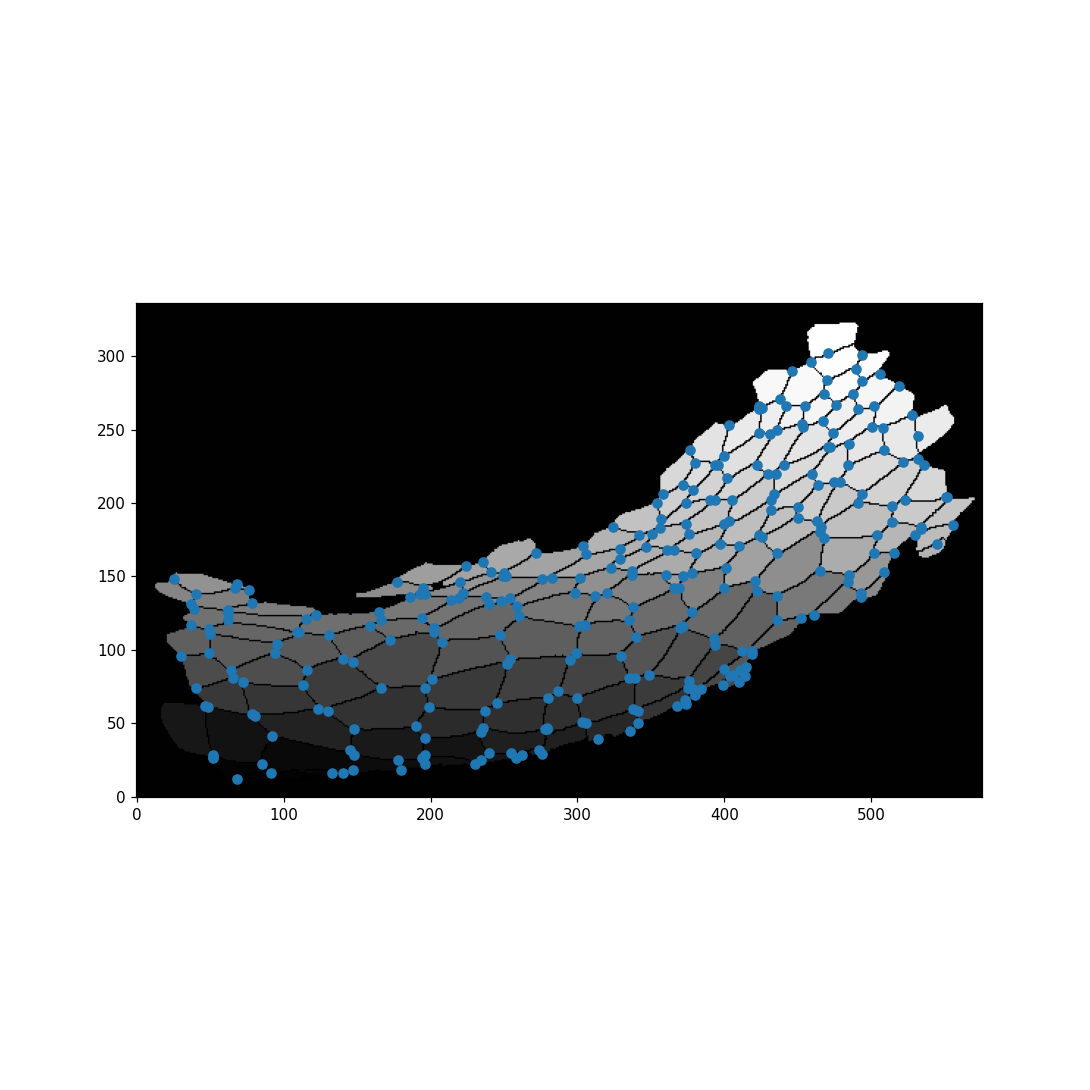

In [130]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(seg,origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(x, y)
#plt.scatter(u, v, color='r', alpha=0.5)


In [122]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(image, origin='lower')

ax.set_aspect('equal')
plt.scatter(x, y, color='r')
#plt.scatter(u, v, color='r', alpha=0.5)

<IPython.core.display.Javascript object>

In [123]:

# import the required library 
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 
  
  
# read the image 
#img = cv2.imread('corner1.png') 
  
# convert image to gray scale image 
gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) 
  
# detect corners with the goodFeaturesToTrack function. 
corners = cv2.goodFeaturesToTrack(gray, 27, 0.01, 10) 
corners = np.int0(corners) 
  
# we iterate through each corner,  
# making a circle at each point that we think is a corner. 
for i in corners: 
    x, y = i.ravel() 
    cv2.circle(img, (x, y), 3, 255, -1) 
  
plt.imshow(img), plt.show() 









error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [124]:
#Récupération des numéros de cellules partageant un vertex
m = []
n = []
o = []
p = []


for k in vertex_moy.values():
    m.append(k[1])
    n.append(k[2])
    o.append(k[3])
    if len(k)>4 :
        p.append(k[4])
    else :
        p.append('Nan')
        
    
#Création d'un DataFrame
init = np.zeros((len(vertex_moy), 6))
df3 = pd.DataFrame(data=init, columns=['cellule a','cellule b','cellule c', 'cellule d',
                                       'coordonée x',
                                       'coordonée y'])
for ind in range (0, len(vertex_moy)):
    
    df3['cellule a'][ind] = m[ind]
    df3['cellule b'][ind] = n[ind]
    df3['cellule c'][ind] = o[ind]
    df3['cellule d'][ind] = p[ind]
    df3['coordonée x'][ind] = x[ind]
    df3['coordonée y'][ind] = y[ind]
  
   

In [125]:
df3

,cellule a,cellule b,cellule c,cellule d,coordonée x,coordonée y
0,1.0,85.0,93.0,NaN,25.0,148.0
1,1.0,49.0,61.0,NaN,30.0,96.0
2,1.0,61.0,73.0,NaN,37.0,117.0
3,1.0,81.0,85.0,NaN,37.0,131.0
4,1.0,73.0,81.0,NaN,39.0,128.0
...,...,...,...,...,...,...
288,116.0,120.0,126.0,NaN,534.0,182.0
289,1.0,134.0,137.0,NaN,536.0,226.0
290,126.0,129.0,137.0,NaN,551.0,204.0
291,1.0,126.0,129.0,137.0,552.0,204.0


In [126]:
#Création d'un DataFrame
init = np.zeros((1,7))
df4_jonctions = pd.DataFrame(columns=['Cell1','Cell2','x0','y0',
                                       'x1','y1',
                                       'angle'])


for ind in range (0,df3.shape[0]): #pour chaque vertex
    print(ind)
    if np.isnan(df3['cellule d'][ind]):
        
        cells_ind = np.array([df3['cellule a'][ind], df3['cellule b'][ind], 
                          df3['cellule c'][ind]])
        for i in range (0,df3.shape[0]): # pour chaque autre vertex
    
    
            cells_i = np.array([df3['cellule a'][i], df3['cellule b'][i], 
                            df3['cellule c'][i], df3['cellule d'][i]])
        
            mask_TrueFalse = np.isin(cells_ind, cells_i)
            if np.sum(mask_TrueFalse) == 2 :
   
    
                dict_jonctions={'Cell1': cells_ind[np.where(mask_TrueFalse)][0],
                    'Cell2': cells_ind[np.where(mask_TrueFalse)][1],
                    'x0' : df3['coordonée x'][i],
                    'y0' : df3['coordonée y'][i],
                    'x1' : df3['coordonée x'][ind],
                    'y1' : df3['coordonée y'][ind],
                    'angle' : np.arctan(
        (df3['coordonée y'][ind]-df3['coordonée y'][i])
        /(df3['coordonée x'][ind]-df3['coordonée x'][i])
    )
                   
                   }

                df4_jonctions=df4_jonctions.append(dict_jonctions, ignore_index = True)
            
            
    
    
    
    
        
    else:
    
        cells_ind = np.array([df3['cellule a'][ind], df3['cellule b'][ind], 
                          df3['cellule c'][ind],df3['cellule d'][ind]])
        for i in range (0,df3.shape[0]): # pour chaque autre vertex
    
    
            cells_i = np.array([df3['cellule a'][i], df3['cellule b'][i], 
                            df3['cellule c'][i],df3['cellule d'][i]])
        
            mask_TrueFalse = np.isin(cells_ind, cells_i)
            if np.sum(mask_TrueFalse) == 3 :
   
    
                dict_jonctions={'Cell1': cells_ind[np.where(mask_TrueFalse)][0],
                    'Cell2': cells_ind[np.where(mask_TrueFalse)][1],
                    'x0' : df3['coordonée x'][i],
                    'y0' : df3['coordonée y'][i],
                    'x1' : df3['coordonée x'][ind],
                    'y1' : df3['coordonée y'][ind],
                    'angle' : np.arctan(
        (df3['coordonée y'][ind]-df3['coordonée y'][i])
        /(df3['coordonée x'][ind]-df3['coordonée x'][i])
    )
                   
                   }

                df4_jonctions=df4_jonctions.append(dict_jonctions, ignore_index = True)








0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars


15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
2

In [127]:
df4_jonctions

,Cell1,Cell2,x0,y0,x1,y1,angle
0,1.0,85.0,37.0,131.0,25.0,148.0,-0.956133
1,85.0,93.0,40.0,138.0,25.0,148.0,-0.588003
2,1.0,93.0,68.0,145.0,25.0,148.0,-0.069655
3,1.0,61.0,37.0,117.0,30.0,96.0,1.249046
4,1.0,49.0,40.0,74.0,30.0,96.0,-1.144169
...,...,...,...,...,...,...,...
905,126.0,129.0,551.0,204.0,552.0,204.0,0.000000
906,1.0,120.0,530.0,178.0,556.0,185.0,0.262995
907,1.0,120.0,545.0,172.0,556.0,185.0,0.868539
908,120.0,126.0,534.0,182.0,556.0,185.0,0.135528


<IPython.core.display.Javascript object>


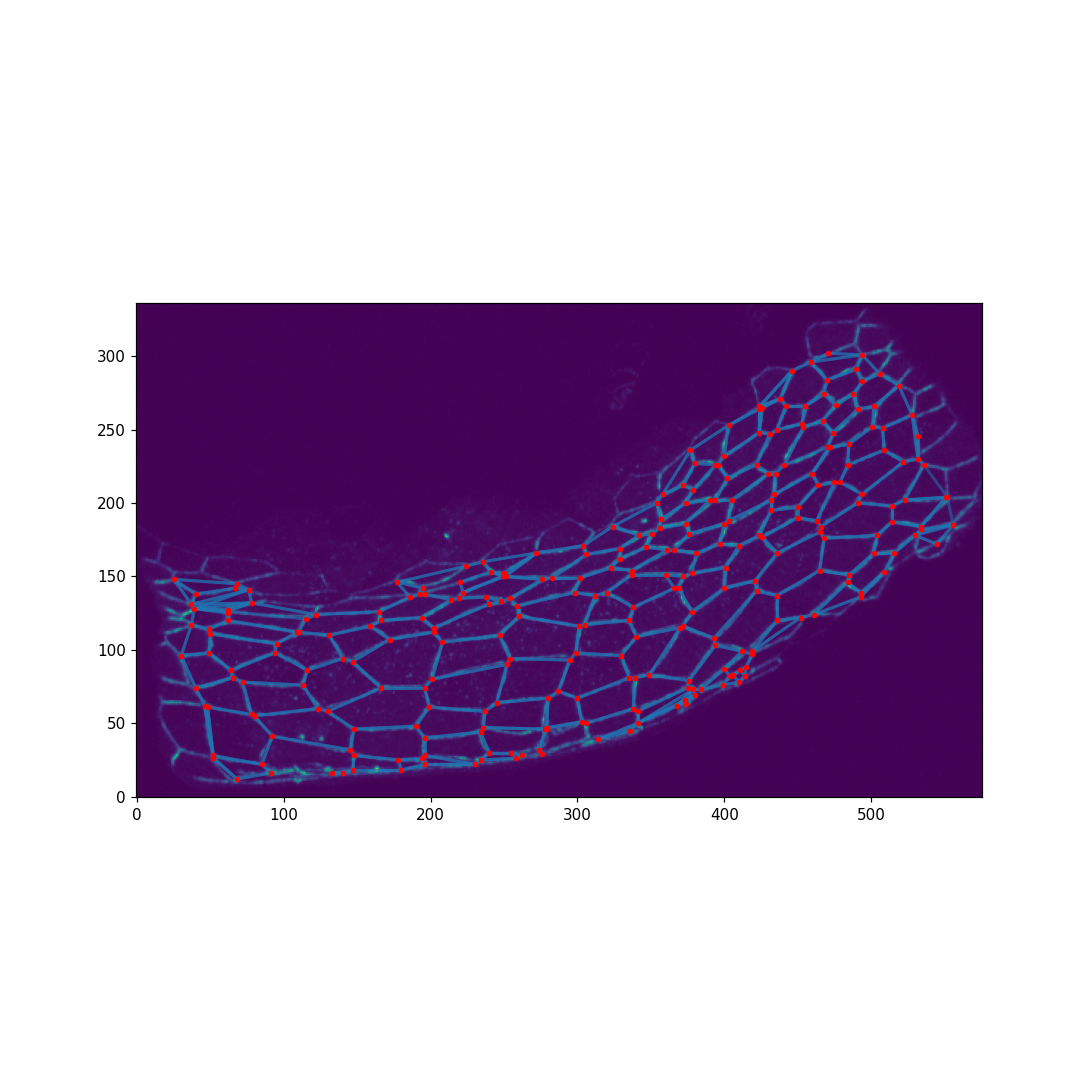

In [128]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

lines=[]
for i in range (0, df4_jonctions.shape[0]) :
    lines.append(([(df4_jonctions['x0'][i],df4_jonctions['y0'][i]),(df4_jonctions['x1'][i],df4_jonctions['y1'][i])]))




cc = df4_jonctions['x0']
lc = mc.LineCollection(lines, cc, cmap='plasma_r', linewidth=2, alpha=0.5)

fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
#ax.autoscale()
#ax.margins(0.1)
ax.scatter(x,y,color='r', zorder=10, s = 7)
ax.set_aspect('equal')

plt.imshow(image, origin='lower')

<IPython.core.display.Javascript object>


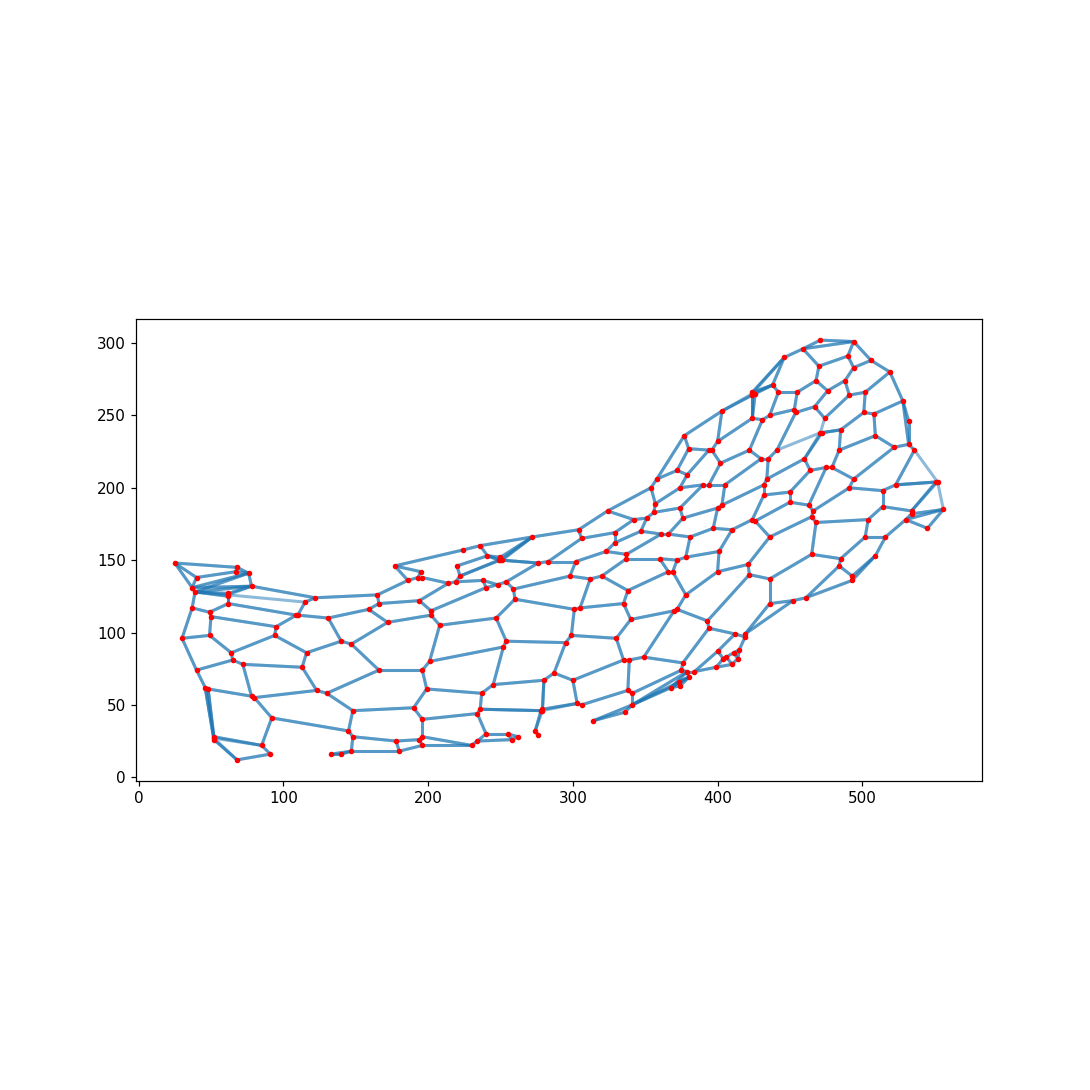

In [129]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

lines=[]
for i in range (0, df4_jonctions.shape[0]) :
    lines.append(([(df4_jonctions['x0'][i],df4_jonctions['y0'][i]),(df4_jonctions['x1'][i],df4_jonctions['y1'][i])]))




cc = df4_jonctions['x0']
lc = mc.LineCollection(lines, cc, cmap='jet', linewidth=2, alpha=0.5)

fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
#ax.autoscale()
#ax.margins(0.1)
ax.scatter(x,y,color='r', zorder=10, s = 7)
ax.set_aspect('equal')

#plt.imshow(image, origin='lower')

# Ellipses

In [50]:
from astropy.modeling import models, fitting
from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle
import warnings
%matplotlib inline
# fitting procedure
fit = fitting.SimplexLSQFitter() 
#fit = fitting.LevMarLSQFitter()

In [51]:
from multiprocessing import Pool
from itertools import repeat
import time



def Cell(seg,i):   
    segmentationi = np.zeros_like(seg)
    #for each cell get contour pixels
    segmentationi[np.where(seg == i)] = 1
    return segmentationi

def cellgeoi(inputs):
    ind,i,seg = inputs
    print(i)

    #Ellipse
    imCell = Cell(seg,i)
    # gaussian fit (to estimate x_0, y_0 and theta)
    gi = models.Gaussian2D(amplitude = 1.,
                           x_mean = np.where(imCell==1)[1][int(len(np.where(imCell == 1)[0]) / 2) + 1],
                           y_mean = np.where(imCell == 1)[0][int(len(np.where(imCell == 1)[0]) / 2) + 1], 
                           x_stddev=10, y_stddev=10, theta=0.0) #modèle initial
    
    g1 = fit(gi, x, y, imCell, maxiter=100000) #fit une gaussienne avec les parametres initiaux donnés
    # initial model: fais une ellipse fixe avec les parametres trouvés par le fit gaussien
    
    ei1 = models.Ellipse2D(amplitude=1.,
                           x_0=g1.x_mean, 
                           y_0=g1.y_mean, 
                           a=g1.x_stddev, 
                           b=g1.y_stddev,
                           theta=g1.theta, 
                           fixed={'x_0': True, 'y_0':True, 'theta':True})
    
    #fitted model : on fit une ellipse et donc on change a et b 
    e1 = fit(ei1, x, y, imCell, maxiter=100000)
    e1.amplitude = 1
    z1 = e1(x, y)
    
    if e1.b.value > e1.a.value:
        e1.theta.value = e1.theta.value + np.pi/2 
        c = e1.a.value  
        e1.a.value = e1.b.value 
        e1.b.value = c
    
    return e1


In [52]:
start = time.time()
y, x = np.mgrid[0:np.shape(seg)[0], 0:np.shape(seg)[1]] #grille 
init = np.zeros((len(np.unique(seg)[2:]),5))
Dataframe_geo_para = pd.DataFrame(data=init,columns=['x_0','y_0','a','b','theta'])

all_inputs = zip(range(len(np.unique(seg)[2:])),np.unique(seg)[2:],repeat(seg))

pool = Pool(4)
CellGeo= pool.map_async(cellgeoi, all_inputs)
pool.close()
pool.join()
e1l = CellGeo.get()

for ind,i in enumerate(np.unique(seg)[2:]):
    print(i)
    Dataframe_geo_para['x_0'][ind] = e1l[ind].x_0.value
    Dataframe_geo_para['y_0'][ind] = e1l[ind].y_0.value
    Dataframe_geo_para['a'][ind] = e1l[ind].a.value
    Dataframe_geo_para['b'][ind] = e1l[ind].b.value
    Dataframe_geo_para['theta'][ind] = e1l[ind].theta.value

Dataframe_geo_para['e'] = np.sqrt( 1 - (Dataframe_geo_para['b']**2 / (Dataframe_geo_para['a']**2) ))
Dataframe_geo_para['an'] = Dataframe_geo_para['a'] / Dataframe_geo_para['b']
Dataframe_geo_para['a um'] = Dataframe_geo_para['a'] * pixel_ratio
Dataframe_geo_para['b um'] = Dataframe_geo_para['b'] * pixel_ratio

#Dataframe_geo_para['e'] = np.sqrt( 1 - (Dataframe_geo_para['b']**2 / (Dataframe_geo_para['a']**2) ))
#Dataframe_geo_para['an'] = Dataframe_geo_para['a'] / Dataframe_geo_para['b']

end=time.time()

print('Cell Geo 4 cores ran in ',(end-start)/60.,' min')

2
14
31
42
43
3
15
32
5
44
16
33
20
46
34
47
21
35
22
36
48
25
37
49
28
38
50
30
39
52
53
63
73
54
64
74
65
55
75
66
57
6
76
67
58
8
77
68
59
9
78
69
60
79
11
71
61


Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/tmerle/

  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/astropy/modeling/core.py", line 914, in __call__
    return generic_call(self, *new_args, **kwargs)
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/scipy/optimize/optimize.py", line 602, in _minimize_neldermead
    fxr = func(xr)
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/astropy/modeling/core.py", line 380, in __call__
    return super(cls, self).__call__(*inputs, **kwargs)
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/astropy/modeling/fitting.py", line 234, in objective_function
    res = self._stat_method(meas, model, *args[1:-1])
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/scipy/optimize/optimize.py", line 327, in function_wrapper
    return function(*(wrapper_args + args))
  File "/home/tmerle/anaconda3/envs/opencv-env/lib/python3.7/site-packages/astropy/modeling/core.py", line 3795, in gen

In [ ]:
e1l

In [ ]:
Dataframe_geo_para

In [ ]:
from multiprocessing import Pool
import time

In [ ]:
Dataframe_geo_para.to_csv('Dataframe_geo_para.csv',index=False)
#Dataframe_geo_para = pd.read_csv('/home/tmerle/Dataframe_geo_para.csv')

In [ ]:
np.mean(Dataframe_geo_para['a um'])

In [ ]:
from matplotlib.colors import LogNorm,PowerNorm

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(seg,origin='lower',cmap=cmap_rand)
for i in range(len(Dataframe_geo_para)):
    startx = Dataframe_geo_para['x_0'][i] - Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    starty = Dataframe_geo_para['y_0'][i] - Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    endx = Dataframe_geo_para['x_0'][i] + Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    endy = Dataframe_geo_para['y_0'][i] + Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    
    
    plt.plot([startx, endx], [starty, endy], color='black')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
#plt.imshow(seg,origin='lower',cmap=cmap_rand)
for i in range(len(Dataframe_geo_para)):
    startx = Dataframe_geo_para['x_0'][i] - Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    starty = Dataframe_geo_para['y_0'][i] - Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    endx = Dataframe_geo_para['x_0'][i] + Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    endy = Dataframe_geo_para['y_0'][i] + Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])

    colori = plt.cm.jet(Dataframe_geo_para['e'][i]) # r is 0 to 1 inclusive
        
    plt.plot([startx, endx], [starty, endy], color=colori)
   
#plt.colorbar(Dataframe_geo_para_bis['e'])

In [ ]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [ ]:
'''Fonction pour la jolie color bar'''

from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [ ]:
%matplotlib notebook

In [ ]:
fig = plt.figure(figsize=(10,9))
ax.set_aspect('equal')
#plt.imshow(seg,origin='lower',cmap='viridis')
plt.imshow(mask,origin='lower',cmap='gist_gray')
xs = []
ys = []
for i in range(len(Dataframe_geo_para)):
    startx = Dataframe_geo_para['x_0'][i] - Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    starty = Dataframe_geo_para['y_0'][i] - Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    endx = Dataframe_geo_para['x_0'][i] + Dataframe_geo_para['a'][i] * np.cos(Dataframe_geo_para['theta'][i])
    endy = Dataframe_geo_para['y_0'][i] + Dataframe_geo_para['a'][i] * np.sin(Dataframe_geo_para['theta'][i])
    
    xs.append([startx,endx])
    ys.append([starty,endy])
c = Dataframe_geo_para['an']
lc = multiline(xs, ys, c, cmap='jet', lw=2, clim = (0,8))
add_colorbar(lc, aspect=0.05, pad_fraction=0.5, label = 'Anisotropy (a/b)')